In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from googleapiclient.discovery import build

In [701]:
from matplotlib import pyplot as plt
import seaborn as sns
from pandas import DataFrame, option_context, to_datetime, read_csv, read_excel, crosstab
import regex as re
from datetime import datetime, date
import numpy as np

In [3]:
# defining the scope of the application
scope_app = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive'] 

#credentials to the account
cred = ServiceAccountCredentials.from_json_keyfile_name('baby-sleep-war-89c8dcb4a508.json',scope_app) 

# authorize the clientsheet 
client = gspread.authorize(cred)

In [4]:
def print_all(text):
    with option_context('display.max_rows', None, 'display.max_columns', None):  
        # more options can be specified also
        print(text)

In [350]:
spreadsheet_id = '1l-bLCA0f4gsYgnDE6aeoTM9nH5uuc48Z1zRw9uHTNjo'
range_name = 'A1:BA1300'
#sh = client.open('baby-sleep_war')

service = build('sheets', 'v4', credentials=cred)
result = service.spreadsheets().values().get(spreadsheetId=spreadsheet_id, range=range_name).execute()
answers = result.get('values', [])
print(f"{len(answers)} rows retrieved")

df_zero = DataFrame(answers[1:], columns=answers[0])
#print(df.info())

1236 rows retrieved


In [562]:
df = df_zero.copy()

col_names_en = {
    '–û—Ç–º–µ—Ç–∫–∞ –≤—Ä–µ–º–µ–Ω–∏': "time",
    '–ê–¥—Ä–µ—Å —ç–ª–µ–∫—Ç—Ä–æ–Ω–Ω–æ–π –ø–æ—á—Ç—ã':	"email",
    '1. –£ —è–∫–æ–º—É –Ω–∞—Å–µ–ª–µ–Ω–æ–º—É –ø—É–Ω–∫—Ç—ñ –£–∫—Ä–∞—ó–Ω–∏ –≤–∏ –ø—Ä–æ–∂–∏–≤–∞–ª–∏ –¥–æ 24 –ª—é—Ç–æ–≥–æ 2022 —Ä–æ–∫—É?':	"location_before",
    '2. –°–∫—ñ–ª—å–∫–∏ –∑–∞—Ä–∞–∑ –≤–∞—à—ñ–π (–º–æ–ª–æ–¥—à—ñ–π) –¥–∏—Ç–∏–Ω—ñ? –î–∞—Ç–∞ –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è —É —Ñ–æ—Ä–º–∞—Ç—ñ –¥–¥.–º–º.—Ä—Ä—Ä—Ä ':	"birthday_younger",
    '3. –°—Ç–∞—Ç—å (–º–æ–ª–æ–¥—à–æ—ó) –¥–∏—Ç–∏–Ω–∏':	"gender_younger",
    '4. –Ø–∫—â–æ —É –≤–∞—Å –±—ñ–ª—å—à–µ, –Ω—ñ–∂ –æ–¥–Ω–∞ –¥–∏—Ç–∏–Ω–∞, –≤–∫–∞–∂—ñ—Ç—å –≤—ñ–∫ (–¥–∞—Ç–∏ –Ω–∞—Ä–æ–¥–∂–µ–Ω–Ω—è) —Å—Ç–∞—Ä—à–∏—Ö –¥—ñ—Ç–µ–π. \n–Ø–∫—â–æ —É –≤–∞—Å —Ç—ñ–ª—å–∫–∏ 1 –¥–∏—Ç–∏–Ω–∞, –ø–æ—Å—Ç–∞–≤—Ç–µ "-", –±—É–¥—å –ª–∞—Å–∫–∞ ':	"birthday_older",
    '5. –°—Ç–∞—Ç—å —Å—Ç–∞—Ä—à–æ—ó –¥–∏—Ç–∏–Ω–∏ (–¥—ñ—Ç–µ–π). –Ø–∫—â–æ —É –≤–∞—Å —Ç—ñ–ª—å–∫–∏ 1 –¥–∏—Ç–∏–Ω–∞, –ø–æ—Å—Ç–∞–≤—Ç–µ "-"  ':	"gender_older",
    '6. –Ø–∫–∏–π —Ç–∏–ø –≤–∏–≥–æ–¥–æ–≤—É–≤–∞–Ω–Ω—è —É –≤–∞—à–æ—ó (–º–æ–ª–æ–¥—à–æ—ó) –¥–∏—Ç–∏–Ω–∏?':	"feeding",
    '7. –ß–∏ —î –æ—Å–æ–±–ª–∏–≤–æ—Å—Ç—ñ —Å—Ç–∞–Ω—É –∑–¥–æ—Ä–æ–≤‚Äô—è –¥–∏—Ç–∏–Ω–∏, –Ω–∞ —è–∫—ñ –≤–∏ –∑–≤–µ—Ä—Ç–∞–ª–∏ —É–≤–∞–≥—É –¥–æ 24 –ª—é—Ç–æ–≥–æ? ':	"health",
    '8. –Ø–∫ –≤–∏ –± –æ—Ü—ñ–Ω–∏–ª–∏ —Å–æ–Ω –≤–∞—à–æ—ó –¥–∏—Ç–∏–Ω–∏ –¥–æ 24 –ª—é—Ç–æ–≥–æ? (–≤—ñ–¥ 1 –¥–æ 5, –¥–µ 1 ‚Äì –∂–∞—Ö–ª–∏–≤–∏–π —Å–æ–Ω, 5 ‚Äì —á—É–¥–æ–≤–∏–π —Å–æ–Ω)? ':	"kidsleep_grade_before",
    '9. –Ø–∫, –Ω–∞ –≤–∞—à—É –¥—É–º–∫—É, –∑–º—ñ–Ω–∏–≤—Å—è —Å–æ–Ω –≤–∞—à–æ—ó –¥–∏—Ç–∏–Ω–∏ —É –ø–µ—Ä—à–∏–π –º—ñ—Å—è—Ü—å –ø–æ–≤–Ω–æ–º–∞—Å—à—Ç–∞–±–Ω–æ—ó –≤—ñ–π–Ω–∏ –≤—ñ–¥ 24 –ª—é—Ç–æ–≥–æ 2022 —Ä–æ–∫—É? ':	"kidsleep_dynamics",
    '10. –ß–∏ –ø—Ä–∞—Ü—é–≤–∞–ª–∏ –≤–∏ –Ω–∞–¥ —Å–Ω–æ–º –¥–∏—Ç–∏–Ω–∏ –¥–æ 24 –ª—é—Ç–æ–≥–æ 2022 —Ä–æ–∫—É?':	"sleep_experience",
    '11. –ß–∏ –∑–∞–ª–∏—à–∞–ª–∏ –≤–∏ –≤–∞—à–µ –º—ñ—Å—Ü–µ –ø—Ä–æ–∂–∏–≤–∞–Ω–Ω—è —Ä–∞–∑–æ–º –∑ –¥—ñ—Ç—å–º–∏ –ø—ñ—Å–ª—è 24 –ª—é—Ç–æ–≥–æ? ':	"leave_home",
    "12. –Ø–∫—â–æ —É –ø–æ–ø–µ—Ä–µ–¥–Ω—å–æ–º—É –ø–∏—Ç–∞–Ω–Ω—ñ –≤–∏ –≤—ñ–¥–ø–æ–≤—ñ–ª–∏ —Ç–∞–∫, —É —è–∫–∏–π –¥–µ–Ω—å –≤–∏ —Ü–µ –∑—Ä–æ–±–∏–ª–∏? –Ø–∫—â–æ –≤–∏ —Ç–æ—á–Ω–æ –Ω–µ –ø–∞–º'—è—Ç–∞—î—Ç–µ –¥–∞—Ç—É, –≤–∫–∞–∂—ñ—Ç—å –ø—Ä–∏–±–ª–∏–∑–Ω–∏–π –¥–µ–Ω—å ":	"when_leave_home",
    '13. –ß–æ–º—É –≤–∏ –ø—Ä–∏–π–Ω—è–ª–∏ —Ä—ñ—à–µ–Ω–Ω—è —Ü–µ –∑—Ä–æ–±–∏—Ç–∏? (–Ø–∫—â–æ –≤–∏ –Ω–µ –∑–∞–ª–∏—à–∞–ª–∏ –º—ñ—Å—Ü–µ –ø—Ä–æ–∂–∏–≤–∞–Ω–Ω—è, –∑–∞–ª–∏—à—Ç–µ "-" —É –≤—ñ–¥–ø–æ–≤—ñ–¥—å –Ω–∞ —Ü–µ –ø–∏—Ç–∞–Ω–Ω—è) ':	"why_leave_home",
    '14. –Ø–∫–∏–º —Ç—Ä–∞–Ω—Å–ø–æ—Ä—Ç–æ–º –≤–∏ –∑–¥—ñ–π—Å–Ω—é–≤–∞–ª–∏ –ø–µ—Ä–µ—ó–∑–¥? ':	"transport_lh",
    '15. –°–∫—ñ–ª—å–∫–∏ –≥–æ–¥–∏–Ω —Ç—Ä–∏–≤–∞–ª–∞ –≤–∞—à–∞ –¥–æ—Ä–æ–≥–∞ –¥–æ –Ω–æ–≤–æ–≥–æ –º—ñ—Å—Ü—è –ø—Ä–æ–∂–∏–≤–∞–Ω–Ω—è? (—Ü–∏—Ñ—Ä–∞, –≥–æ–¥–∏–Ω) ':	"lh_duration",
    '16. –Ø–∫ –±—É–≤ –æ—Ä–≥–∞–Ω—ñ–∑–æ–≤–∞–Ω–∏–π —Å–æ–Ω –¥–∏—Ç–∏–Ω–∏ –ø—ñ–¥ —á–∞—Å –¥–æ—Ä–æ–≥–∏? ':	"kidsleep_lh",
    '17. –£ —è–∫—É –ª–æ–∫–∞—Ü—ñ—é –≤–∏ –∑–º—É—à–µ–Ω—ñ –±—É–ª–∏ –ø–µ—Ä–µ—ó—Ö–∞—Ç–∏? ':	"new_location",
    '18. –ß–∏ –±—É–≤ —É –≤–∞—Å –¥–æ—Å–≤—ñ–¥ –ø–µ—Ä–µ–±—É–≤–∞–Ω–Ω—è –∑ –¥–∏—Ç–∏–Ω–æ—é —É –±–æ–º–±–æ—Å—Ö–æ–≤–∏—â—ñ/–ø—ñ–¥–≤–∞–ª—ñ? ':	"shelter_experience",
    '19. –ß–∏ –±—É–≤ —É –≤–∞—Å –¥–æ—Å–≤—ñ–¥ —Å–Ω—É –∑ –¥–∏—Ç–∏–Ω–æ—é —É –±–æ–º–±–æ—Å—Ö–æ–≤–∏—â—ñ/–ø—ñ–¥–≤–∞–ª—ñ? ':	"shelter_kidsleep",
    '20. –Ø–∫ –±—É–ª–æ —É —Å—Ö–æ–≤–∏—â—ñ –æ—Ä–≥–∞–Ω—ñ–∑–æ–≤–∞–Ω–µ –º—ñ—Å—Ü–µ –¥–ª—è —Å–Ω—É –¥–∏—Ç–∏–Ω–∏? ':	"shelter_organisation",
    '21. –ß–∏ –¥–æ–≤–æ–¥–∏–ª–æ—Å—è –≤–∞–º –≤–∫–ª–∞–¥–∞—Ç–∏ —Å–ø–∞—Ç–∏ –¥–∏—Ç–∏–Ω—É —É –≤–µ—Ä—Ö–Ω—å–æ–º—É –æ–¥—è–∑—ñ? ':	"outerwear_kidsleep",
    '22. –ß–∏ –¥–æ–≤–æ–¥–∏–ª–æ—Å—è –≤–∞–º –≤–∫–ª–∞–¥–∞—Ç–∏ —Å–ø–∞—Ç–∏ –¥–∏—Ç–∏–Ω—É –ø—Ä–∏ –Ω–∏–∑—å–∫—ñ–π —Ç–µ–º–ø–µ—Ä–∞—Ç—É—Ä—ñ –≤ –ø—Ä–∏–º—ñ—â–µ–Ω–Ω—ñ? ':	"coldroom_kidsleep",
    '23. –ß–∏ –¥–æ–≤–µ–ª–æ—Å—è –≤–∞–º –∑–Ω–∞—Ö–æ–¥–∏—Ç–∏—Å—è —É —Å–∏—Ç—É–∞—Ü—ñ—ó –∑ –æ–±–º–µ–∂–µ–Ω–∏–º –¥–æ—Å—Ç—É–ø–æ–º –¥–æ –ø–∏—Ç–Ω–æ—ó –≤–æ–¥–∏? ':	"lack_water",
    '24. –°–∫—ñ–ª—å–∫–∏ –¥–Ω—ñ–≤ –≤–∏ –∑–Ω–∞—Ö–æ–¥–∏–ª–∏—Å—è —É —Å–∏—Ç—É–∞—Ü—ñ—ó –æ–±–º–µ–∂–µ–Ω–æ–≥–æ –¥–æ—Å—Ç—É–ø—É –¥–æ –≤–æ–¥–∏? ':	"lack_water_duration",
    '25. –ß–∏ –¥–æ–≤–µ–ª–æ—Å—è –≤–∞–º –∑–Ω–∞—Ö–æ–¥–∏—Ç–∏—Å—è —É —Å–∏—Ç—É–∞—Ü—ñ—ó –∑ –æ–±–º–µ–∂–µ–Ω–∏–º –¥–æ—Å—Ç—É–ø–æ–º –¥–æ –ø—Ä–æ–¥—É–∫—Ç—ñ–≤ —Ö–∞—Ä—á—É–≤–∞–Ω–Ω—è? ':	"lack_food",
    '26. –ß–∏ –±—É–≤ —É –≤–∞—Å –¥–æ—Å–≤—ñ–¥ –ø–µ—Ä–µ–±—É–≤–∞–Ω–Ω—è –∑ –¥–∏—Ç–∏–Ω–æ—é –±–µ–∑ –µ–ª–µ–∫—Ç—Ä–æ–µ–Ω–µ—Ä–≥—ñ—ó? ':	"lack_elecricity",
    '27. –ß–∏ –¥–æ–≤–µ–ª–æ—Å—è –≤–∞–º —Ä–æ–∑–ª—É—á–∏—Ç–∏ –¥–∏—Ç–∏–Ω—É –∑ —Ä—ñ–¥–Ω–∏–º–∏, –∑–≤–∏—á–Ω–∏–º –æ—Ç–æ—á–µ–Ω–Ω—è–º? ':	"kid_separation",
    '28. –ß–∏ –±—É–≤ —É –≤–∞—Å –¥–æ—Å–≤—ñ–¥ –≤–∫–ª–∞–¥–∞–Ω–Ω—è –¥–∏—Ç–∏–Ω–∏ —É –∫–æ—Ä–∏–¥–æ—Ä—ñ –∫–≤–∞—Ä—Ç–∏—Ä–∏/–±—É–¥–∏–Ω–∫—É ¬´–∑–∞ –ø—Ä–∞–≤–∏–ª–æ–º –¥–≤–æ—Ö —Å—Ç—ñ–Ω¬ª? ':	"2walls",
    '29. –Ø–∫ –±—É–ª–æ –æ—Ä–≥–∞–Ω—ñ–∑–æ–≤–∞–Ω–µ —Å–ø–∞–ª—å–Ω–µ –º—ñ—Å—Ü–µ –¥–∏—Ç–∏–Ω–∏ —É –∫–æ—Ä–∏–¥–æ—Ä—ñ?':	"2walls_sleeporganization",
    '30. –Ø–∫ –≤–∏ –≤–∫–ª–∞–¥–∞–ª–∏ –¥–∏—Ç–∏–Ω—É –¥–æ 24 –ª—é—Ç–æ–≥–æ? ':	"sleep_method_before",
    '31. –ß–∏ –∑–º—ñ–Ω–∏–≤—Å—è –≤–∞—à —Å–ø–æ—Å—ñ–± –≤–∫–ª–∞–¥–∞–Ω–Ω—è –¥–∏—Ç–∏–Ω–∏ –ø—ñ—Å–ª—è 24 –ª—é—Ç–æ–≥–æ? ':	"sleep_method_change",
    '32. –Ø–∫ –∑–º—ñ–Ω–∏–ª–æ—Å—è –≤–∞—à–µ –≤–∫–ª–∞–¥–∞–Ω–Ω—è –¥–∏—Ç–∏–Ω–∏ —É –ª—é—Ç–æ–º—É-–±–µ—Ä–µ–∑–Ω—ñ? ':	"sleep_method_after",
    '33. –ß–∏ –∑–º—ñ–Ω–∏–ª–∞—Å—å –∫—ñ–ª—å–∫—ñ—Å—Ç—å –Ω—ñ—á–Ω–∏—Ö –ø—Ä–æ–±—É–¥–∂–µ–Ω—å –¥–∏—Ç–∏–Ω–∏ —É –ª—é—Ç–æ–º—É-–±–µ—Ä–µ–∑–Ω—ñ? ':	"night_wakings_after",
    '34. –Ø–∫ –≤–∫–ª–∞–¥–∞—î—Ç—å—Å—è –≤–∞—à–∞ –¥–∏—Ç–∏–Ω–∞ –∑–∞—Ä–∞–∑, —É —Å–µ—Ä–ø–Ω—ñ-–≤–µ—Ä–µ—Å–Ω—ñ? ':	"sleep_method_now",
    '35. –ß–∏ –ø—Ä–æ–∫–∏–¥–∞—î—Ç—å—Å—è –≤–∞—à–∞ –¥–∏—Ç–∏–Ω–∞ —á–∏ –≤–∏ –≤–Ω–æ—á—ñ –ø—ñ–¥ —á–∞—Å —Å–∏—Ä–µ–Ω–∏ –ø–æ–≤—ñ—Ç—Ä—è–Ω–æ—ó —Ç—Ä–∏–≤–æ–≥–∏?':	"siren_wakeup",
    '36. –ß–∏ –∑–º—ñ–Ω–∏–≤—Å—è –≤–∞—à —Å–æ–Ω —É –ª—é—Ç–æ–º—É-–±–µ—Ä–µ–∑–Ω—ñ? –û–ø–∏—à—ñ—Ç—å, –±—É–¥—å –ª–∞—Å–∫–∞, —è–∫ –≤–∏ —Å–ø–∞–ª–∏ —É –ø–µ—Ä—à—ñ –¥–Ω—ñ –≤—ñ–π–Ω–∏ —Ä–∞–∑–æ–º —ñ–∑ –º–∞–ª—é–∫–æ–º, —ñ —è–∫ –≤–∞–º –≤–¥–∞–≤–∞–ª–æ—Å—è –ø–æ—Å–ø–∞—Ç–∏, —ñ —á–∏ –≤–¥–∞–≤–∞–ª–æ—Å—è —Ü–µ. ':	"momsleep_war",
    '37. –ß–∏ –≤—ñ–¥—Ä—ñ–∑–Ω—è—î—Ç—å—Å—è –≤–∞—à —Å–æ–Ω –∑–∞—Ä–∞–∑ –≤—ñ–¥ —Ç–æ–≥–æ, —è–∫ –≤–∏ —Å–ø–∞–ª–∏ —É –ª—é—Ç–æ–º—É-–±–µ—Ä–µ–∑–Ω—ñ? ':	"momsleep_now",
    '38. –ß–∏ –∑–º—ñ–Ω–∏–ª–∏ –≤–∏ –∑–∞—Ä–∞–∑ –ª–æ–∫–∞—Ü—ñ—é —Å–≤–æ–≥–æ –ø—Ä–æ–∂–∏–≤–∞–Ω–Ω—è –ø–æ—Ä—ñ–≤–Ω—è–Ω–æ –∑ –ª—é—Ç–∏–º-–±–µ—Ä–µ–∑–Ω–µ–º 2022 —Ä–æ–∫—É? ':	"location_now",
    '39. –†–æ–∑–∫–∞–∂—ñ—Ç—å, –±—É–¥—å –ª–∞—Å–∫–∞, —Å–≤–æ—é —ñ—Å—Ç–æ—Ä—ñ—é ‚Äì —è–∫ –≤–∏ –∑ –¥–∏—Ç–∏–Ω–æ—é –ø–µ—Ä–µ–∂–∏–≤–∞–ª–∏ –≤—Å—ñ –ø–æ–¥—ñ—ó –∑ 24 –ª—é—Ç–æ–≥–æ. –ú–æ–∂–ª–∏–≤–æ, –≤–∏ —Ö–æ—Ç—ñ–ª–∏ –± –¥–æ–ø–æ–≤–Ω–∏—Ç–∏ —Å–≤–æ—ó –≤—ñ–¥–ø–æ–≤—ñ–¥—ñ –Ω–∞ –ø–∏—Ç–∞–Ω–Ω—è, –∑ —É—Ä–∞—Ö—É–≤–∞–Ω–Ω—è–º —Ç–æ–≥–æ, —â–æ –Ω–µ –±—É–ª–æ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–æ —É —Ü—ñ–π –∞–Ω–∫–µ—Ç—ñ. ':	"story_war",
    '40. –ß–æ–≥–æ –≤–∞–º –Ω–µ –≤–∏—Å—Ç–∞—á–∞–ª–æ —É –ø–µ—Ä—à—ñ –º—ñ—Å—è—Ü—ñ –ø—ñ—Å–ª—è 24 –ª—é—Ç–æ–≥–æ? ':	"defficiency",
    '41. –í–∞—à–∞ —Å—Ç–∞—Ç—å':	"gender",
    '42. –°–∫—ñ–ª—å–∫–∏ –≤–∞–º –ø–æ–≤–Ω–∏—Ö —Ä–æ–∫—ñ–≤? (–í–∫–∞–∂—ñ—Ç—å, –±—É–¥—å –ª–∞—Å–∫–∞, —Ü–∏—Ñ—Ä—É)':	"age_parent",
    '43. –í–∞—à–∞ –æ—Å–≤—ñ—Ç–∞':	"education",
    '44. –î–æ—Ö—ñ–¥ –≤–∞—à–æ—ó —Ä–æ–¥–∏–Ω–∏ –≤—ñ–¥–Ω–æ—Å–Ω–æ —ñ–Ω—à–∏—Ö –≥—Ä–æ–º–∞–¥—è–Ω –£–∫—Ä–∞—ó–Ω–∏ –≤–∏ –º–æ–∂–µ—Ç–µ –æ—Ü—ñ–Ω–∏—Ç–∏ —è–∫:':	"income_level",
    '45. –Ø–∫–∏–π –∑–∞—Ä–∞–∑ —Å—Ç–∞—Ç—É—Å –≤–∞—à–∏—Ö —Å—Ç–æ—Å—É–Ω–∫—ñ–≤':	"relationship",
    '46. –ß–∏ —î —É –≤–∞—Å –ø–∏—Ç–∞–Ω–Ω—è, –Ω–∞ —è–∫—ñ –± –≤–∏ —Ö–æ—Ç—ñ–ª–∏ –æ—Ç—Ä–∏–º–∞—Ç–∏ –≤—ñ–¥–ø–æ–≤—ñ–¥—ñ –≤—ñ–¥ –º–µ–Ω–µ? ':	"questions",
    '47. –©–æ, –Ω–∞ –≤–∞—à—É –¥—É–º–∫—É, –º–æ–≥–ª–æ –± –≤–∞—Å –∑–∞—Ä–∞–∑ –ø—ñ–¥—Ç—Ä–∏–º–∞—Ç–∏? ':	"support",
    '48. –ß–∏ —î —è–∫–µ—Å—å –ø–æ–≤—ñ–¥–æ–º–ª–µ–Ω–Ω—è, —è–∫–µ –± –≤–∏ —Ö–æ—Ç—ñ–ª–∏ –ø–µ—Ä–µ–¥–∞—Ç–∏ –º—ñ–∂–Ω–∞—Ä–æ–¥–Ω—ñ–π —Å–ø—ñ–ª—å–Ω–æ—Ç—ñ, —è–∫—ñ–π —è –±—É–¥—É —Ä–æ–∑–ø–æ–≤—ñ–¥–∞—Ç–∏ –ø—Ä–æ —Ç–µ, —è–∫ –∑–∞—Ä–∞–∑ —É–∫—Ä–∞—ó–Ω—Å—å–∫—ñ –±–∞—Ç—å–∫–∏ –ø–µ—Ä–µ–∂–∏–≤–∞—é—Ç—å –≤–∞–∂–∫—ñ –ø–æ–¥—ñ—ó —Ä–∞–∑–æ–º –∑ –º–∞–ª—é–∫–æ–º? ':	"message",
    '49. –Ø –ø–æ–≥–æ–¥–∂—É—é—Å—è –Ω–∞ –∞–Ω–æ–Ω—ñ–º–Ω–µ –ø—É–±–ª—ñ—á–Ω–µ —Ü–∏—Ç—É–≤–∞–Ω–Ω—è —Å–≤–æ—ó—Ö —Ä–æ–∑—à–∏—Ä–µ–Ω–∏—Ö –≤—ñ–¥–ø–æ–≤—ñ–¥–µ–π –Ω–∞ –¥–µ—è–∫—ñ –ø–∏—Ç–∞–Ω–Ω—è —Ü—ñ—î—ó –∞–Ω–∫–µ—Ç–∏ ':	"quote",
    '50. –Ø –¥–∞—é –¥–æ–∑–≤—ñ–ª –Ω–∞ –æ–±—Ä–æ–±–∫—É –¥–∞–Ω–∏—Ö —ñ–∑ —Ü—ñ—î—ó –∞–Ω–∫–µ—Ç–∏ –¥–ª—è –ø–æ–¥–∞–ª—å—à–æ–≥–æ –∞–Ω–∞–ª—ñ–∑—É —Ç–∞ –ø—É–±–ª—ñ–∫–∞—Ü—ñ—ó —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ñ–≤':	"informed_consent",
    '51. –ß–∏ –±–∞–∂–∞—î—Ç–µ –≤–∏ –æ—Ç—Ä–∏–º–∞—Ç–∏ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∏ –¥–æ—Å–ª—ñ–¥–∂–µ–Ω–Ω—è —á–∏ –≤—ñ–¥–ø–æ–≤—ñ–¥—ñ –Ω–∞ –≤–∞—à—ñ –∑–∞–ø–∏—Ç–∞–Ω–Ω—è –Ω–∞ –≤–∞—à—É –µ–ª–µ–∫—Ç—Ä–æ–Ω–Ω—É –ø–æ—à—Ç—É?': "feedback"}

df.rename(columns=col_names_en, inplace=True)
df.columns

Index(['time', 'email', 'location_before', 'birthday_younger',
       'gender_younger', 'birthday_older', 'gender_older', 'feeding', 'health',
       'kidsleep_grade_before', 'kidsleep_dynamics', 'sleep_experience',
       'leave_home', 'when_leave_home', 'why_leave_home', 'transport_lh',
       'lh_duration', 'kidsleep_lh', 'new_location', 'shelter_experience',
       'shelter_kidsleep', 'shelter_organisation', 'outerwear_kidsleep',
       'coldroom_kidsleep', 'lack_water', 'lack_water_duration', 'lack_food',
       'lack_elecricity', 'kid_separation', '2walls',
       '2walls_sleeporganization', 'sleep_method_before',
       'sleep_method_change', 'sleep_method_after', 'night_wakings_after',
       'sleep_method_now', 'siren_wakeup', 'momsleep_war', 'momsleep_now',
       'location_now', 'story_war', 'defficiency', 'gender', 'age_parent',
       'education', 'income_level', 'relationship', 'questions', 'support',
       'message', 'quote', 'informed_consent', 'feedback'],
      dtype

## Location before the war

Correct the typos in the initial table with the dictionary

- read from Excel from the sheet, that conrains appropriate information, 
- switch to lowercase for the needed columns, 
- turn the columns into dictionary

In [563]:
df_corrections = read_excel('../data/settlements_of_Ukraine.xlsx', sheet_name='corrections_cities')
df_corrections.initial = df_corrections.initial.str.lower()
df_corrections.corrected = df_corrections.corrected.str.lower()
dic_corrections = df_corrections.loc[~df_corrections.corrected.isna()].set_index('initial')['corrected'].to_dict()
#dic_corrections


Clean the data:

- replace the town names corrected in the dictionary above
- replace abbreviations for city/village
- delete names of the regions
- correct multiple variants of city/town/village names and typos
- print the number of unique town names in the table

In [564]:
dic_place = {'—Å–µ–ª–æ':'',
        '—Å. ':'',
        '–ø–ø':'',
        '—Å–º—Ç. ':'',
        '—Å–º—Ç ':''}

dic_region = {
        '–∫–∏—ó–≤—Å—å–∫–∞ –æ–±–ª–∞—Å—Ç—å': '',
        '–∫–∏—ó–≤—Å—å–∫–∞ –æ–±–ª':'',
        '–∫–∏—ó–≤—Å—å–∫–æ—ó –æ–±–ª':'',
        '–∫–∏—ó–≤—Å—å–∫–æ—ó –æ–±–ª–∞—Å—Ç—ñ':'',
        '–≤–æ–ª–∏–Ω—Å—å–∫–∞ –æ–±–ª':'',
        '–≤—ñ–Ω–Ω–∏—Ü—å–∫–∞ –æ–±–ª':'',
        '–¥–Ω—ñ–ø—Ä–æ–ø–µ—Ç—Ä–æ–≤—Å—å–∫–∞ –æ–±–ª':'',
        '–¥–Ω—ñ–ø–æ–æ–ø–µ—Ç—Ä–æ–≤—Å—å–∫–∞ –æ–±–ª':'',
        '–¥–Ω—ñ–ø—Ä–æ–æ–ø–µ—Ç—Ä–æ–≤—Å–∫–∞—è –æ–±–ª':'',
        '–¥–Ω—ñ–ø—Ä–æ–ø–µ—Ç—Ä–æ–≤—Å—å–∫–æ—ó –æ–±–ª–∞—Å—Ç—ñ':'',
        '(–¥–Ω—ñ–ø—Ä–æ–ø–µ—Ç—Ä–æ–≤—Å—å–∫–∞)':'',
        '–¥–Ω—ñ–ø—Ä–æ–æ–ø–µ—Ç—Ä–æ–≤—Å–∫–∞—è –æ–±–ª':'',
        '–¥–æ–Ω–µ—Ü—å–∫–∞ –æ–±–ª':'',
        '–∂–∏—Ç–æ–º–∏—Ä—Å—å–∫–∞ –æ–±–ª':'',
        '–∂–∏—Ç–æ–º–∏—Ä—Å—å–∫–æ—ó –æ–±–ª–∞—Å—Ç—ñ':'',
        '–∑–∞–∫–∞—Ä–ø–∞—Ç—Å—å–∫–∞ –æ–±–ª':'',
        '–∫—ñ—Ä–æ–≤–æ–≥—Ä–∞–¥—Å—å–∫–∞ –æ–±–ª':'',
        '–ª—å–≤—ñ–≤—Å—å–∫–æ—ó –æ–±–ª':'',
        '–ª—å–≤—ñ–≤—Å—å–∫–∞ –æ–±–ª':'',
        '–ª—å–≤—ñ–≤—Å—å–∫–æ—ó –æ–±–ª–∞—Å—Ç—ñ':'',
        '–ª—É–≥–∞–Ω—Å—å–∫–∞ –æ–±–ª':'',
        '—ñ–≤–∞–Ω–æ-—Ñ—Ä–∞–Ω–∫—ñ–≤—Å—å–∫–∞ –æ–±–ª':'',
        '–º–∏–∫–æ–ª–∞—ó–≤—Å—å–∫–∞ –æ–±–ª':'',
        '–æ–¥–µ—Å—å–∫–∞ –æ–±–ª':'',
        '—Ä—ñ–≤–Ω–µ–Ω—Å—å–∫–∞ –æ–±–ª':'',
        ', –ø–æ–ª—Ç–∞–≤—Å—å–∫–∞ –æ–±–ª–∞—Å—Ç—å': '',
        '–ø–æ–ª—Ç–∞–≤—Å—å–∫–∞ –æ–±–ª':'',
        '—Å—É–º—Å—å–∫–∞ –æ–±–ª':'',
        '—Ç–µ—Ä–Ω–æ–ø—ñ–ª—å—Å—å–∫–∞ –æ–±–ª':'',
        '—Ç–µ—Ä–Ω–æ–ø—ñ–ª—å—Å—å–∫—ñ–π –æ–±–ª–∞—Å—Ç—ñ':'',
        '—Ö–∞—Ä–∫—ñ–≤—Å—å–∫–∞–æ–±–ª':'',
        '—Ö–∞—Ä–∫—ñ–≤—Å—å–∫–∞ –æ–±–ª':',',
        '—Ö–∞—Ä–∫—ñ–≤—Å—å–∫–∏–π —Ä–∞–π–æ–Ω':'',
        '—Ö–∞—Ä–∫—ñ–≤—Å—å–∫–∏–π —Ä–Ω':'',
        '—Ö–∞—Ä–∫—ñ—Å–∫—å—Å–∫–∞ –æ–±–ª ':'',
        '—Ö–µ—Ä—Å–æ–Ω—Å—å–∫–∞ –æ–±–ª':'',
        '—á–µ—Ä–Ω—ñ–≥—ñ–≤—Å—å–∫–∞ –æ–±–ª':'',
        '—á–µ—Ä–Ω—ñ–≤–µ—Ü—å–∫–∞ –æ–±–ª':'',
        '—á–µ—Ä–∫–∞—Å—å–∫–∞ –æ–±–ª':'',
        '—Ñ–∞—Å—Ç—ñ–≤—Å—å–∫–∞ –æ–±–ª':'',
        '–∫–∏—ó–≤1':'–∫–∏—ó–≤',
        '–∫–∏—ó–≤“ë':'–∫–∏—ó–≤',
        '–∫–∏—ñ–≤':'–∫–∏—ó–≤',
        '–º.–∫–∏—ó–≤':'–∫–∏—ó–≤',
        '–∫–∏–µ–≤':'–∫–∏—ó–≤',
        '–∏—Ä–ø–µ–Ω—å': '—ñ—Ä–ø—ñ–Ω—å',
        'irpin': '—ñ—Ä–ø—ñ–Ω—å',
        '–¥–Ω–µ–ø—Ä':'–¥–Ω—ñ–ø—Ä–æ',
        '—Ö–∞—Ä—å–∫–æ–≤':'—Ö–∞—Ä–∫—ñ–≤',
        '–≥–µ—Ä–æ–π —Ö–∞—Ä–∫—ñ–≤':'—Ö–∞—Ä–∫—ñ–≤',
        '—Ö–∞—Ä—å–∫—ñ–≤':'—Ö–∞—Ä–∫—ñ–≤',
        '—Ö–∞—Ä—ñ–≤':'—Ö–∞—Ä–∫—ñ–≤',
        '—Ö–∞—Ä—å–∫–æ':'—Ö–∞—Ä–∫—ñ–≤',
        '–∫—Ä–µ–º–µ–Ω—á—É—Ü—ñ':'–∫—Ä–µ–º–µ–Ω—á—É–∫',
        '–∫–æ–µ–º–µ–Ω—á—É–∫':'–∫—Ä–µ–º–µ–Ω—á—É–∫',
        '–∫—Ä–µ–º–µ–Ω—á—É–≥':'–∫—Ä–µ–º–µ–Ω—á—É–∫',
        '—ñ–≤–∞–Ω–æ-—Ñ—Ä–∞–Ω–∫—ñ–≤—Å—å–∫—É':'—ñ–≤–∞–Ω–æ-—Ñ—Ä–∞–Ω–∫—ñ–≤—Å—å–∫',
        '–∑–∞–ø–æ—Ä–æ–∂—å–µ':'–∑–∞–ø–æ—Ä—ñ–∂–∂—è',
        '–æ–¥–µ—Å—Å–∞':'–æ–¥–µ—Å–∞'
        }

df.location_before = df.location_before.str.lower()
df.location_before = df.location_before.str.strip()
#print(df.location_before[df['location_before'].str.contains('—Ö–º–µ–ª—å–Ω–∏—Ü–∫', case=False)])
df.location_before = df.location_before.replace(dic_corrections, regex=True)
#print(df.location_before[df['location_before'].str.contains('—Ö–º–µ–ª—å–Ω–∏—Ü–∫', case=False)])
city = df.location_before
city = city.replace(['–º\.', '^–º\.', ' –º ', ',–º', '–º—ñ—Å—Ç–æ', ' –≥–æ—Ä–æ–¥'], '', regex=True)
city = city.replace(['–æ–±–ª–∞—Å—Ç—å','–æ–±–ª–∞—á—Ç—å', '–æ–±–ª–∞—Å—Ç—ñ'], '–æ–±–ª', regex=True)
city = city.replace(dic_place, regex=True)
city = city.str.strip()
city = city.replace(dic_region, regex=True)
city = city.str.replace('[^\w\s]','', regex=True)
city = city.str.strip()
city = city.replace(['—ñ–≤–∞–Ω–æ —Ñ—Ä–∞–Ω–∫—ñ–≤—Å—å–∫', '—ñ–≤–∞–Ω–æ—Ñ—Ä–∞–Ω–∫—ñ–≤—Å—å–∫', '—ñ–≤–∞–Ω–æ  —Ñ—Ä–∞–Ω–∫—ñ–≤—Å—å–∫'], '—ñ–≤–∞–Ω–æ—Ñ—Ä–∞–Ω–∫—ñ–≤—Å—å–∫', regex=True)
city = city.replace('—Ö–∞—Ä–∫—ñ–≤ –ø—ñ–≤–Ω—ñ—á–Ω–∞ —Å–∞–ª—Ç—ñ–≤–∫–∞', '—Ö–∞—Ä–∫—ñ–≤')
city = city.replace('–∫—Ä–æ–ø–∏–≤–Ω–∏—Ü—å–∫–∏–π –∫—ñ—Ä–æ–≤–æ–≥—Ä–∞–¥', "–∫—Ä–æ–ø–∏–≤–Ω–∏—Ü—å–∫–∏–π") 
#city = city.replace('–∫–∞–º—è–Ω–µ—Ü—å–ø–æ–¥—ñ–ª—å—Å—å–∫–∏–π', "–∫–∞–º'—è–Ω–µ—Ü—å-–ø–æ–¥—ñ–ª—å—Å—å–∫–∏–π")
print('–ö—ñ–ª—å–∫—ñ—Å—Ç—å –Ω–∞—Å–µ–ª–µ–Ω–∏—Ö –ø—É–Ω–∫—Ç—ñ–≤ —Å–µ—Ä–µ–¥ —Ä–µ—Å–ø–æ–Ω–¥–µ–Ω—Ç—ñ–≤:', len(city.unique()))

df_city = city.value_counts()
print_all(df_city.sort_values())
df['city'] = city

#df[['city_raw', 'city']].to_csv(r'city.csv', index = False)
#df[['city_raw', 'city']][df['city']=='']


–ö—ñ–ª—å–∫—ñ—Å—Ç—å –Ω–∞—Å–µ–ª–µ–Ω–∏—Ö –ø—É–Ω–∫—Ç—ñ–≤ —Å–µ—Ä–µ–¥ —Ä–µ—Å–ø–æ–Ω–¥–µ–Ω—Ç—ñ–≤: 176
–∫—Ä—é–∫—ñ–≤—â–∏–Ω–∞                 1
–ª–æ—Ö–≤–∏—Ü—è                    1
—Ä—É–¥–Ω–æ                      1
–∑–æ–ª–æ—Ç–æ–Ω–æ—à–∞                 1
–∫–æ—Ä–æ—Ç–∏—á                    1
–¥–æ–±—Ä–æ—Ç–≤—ñ—Ä                  1
–≤–æ—Ä–∑–µ–ª—å                    1
–∫–æ—Ä–µ—Ü—å                     1
—Å—Ç–∞—Ä–æ–∫–æ—Å—Ç—è–Ω—Ç–∏–Ω—ñ–≤           1
–∑–¥–≤–∏–∂—ñ–≤–∫–∞                  1
–≤—É–≥–ª–µ–¥–∞—Ä                   1
–∫–∏—Å–ª–∏—Ü—è                    1
–ø–∞–≤–ª–∏—à                     1
—Å—Ç—Ä–∞–¥—á                     1
–º–∞–∫–∞—Ä—ñ–≤                    1
–∫–∞–º—è–Ω–æ–±—Ä—ñ–¥                 1
–æ–≤—Ä—É—á                      1
–ø–æ–∫—Ä–æ–≤—Å—å–∫                  1
–≥—É–±–∏–Ω–∏—Ö–∞                   1
–≥–∞—Ç–Ω–µ                      1
–∫–æ–ª–æ–Ω—â–∏–Ω–∞                  1
—Å–æ—Ñ—ñ—ó–≤–∫–∞                   1
—Å–≤—è—Ç–æ–≥—ñ—Ä—Å—å–∫                1
–ø—è—Ç–∏—Ö–∞—Ç–∫–∏                  1
–º–æ—â—É–Ω      

Assign towns to regions

Dictionary for alligning places to regions, source: https://uk.wikipedia.org/wiki/%D0%92%D1%96%D0%BA%D1%96%D0%BF%D0%B5%D0%B4%D1%96%D1%8F:%D0%9F%D1%80%D0%BE%D1%94%D0%BA%D1%82:%D0%9D%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D1%96_%D0%BF%D1%83%D0%BD%D0%BA%D1%82%D0%B8_%D0%A3%D0%BA%D1%80%D0%B0%D1%97%D0%BD%D0%B8 (–ü—Ä–æ—î–∫—Ç –Ω–∞—Å–µ–ª–µ–Ω—ñ –ø—É–Ω–∫—Ç–∏ –£–∫—Ä–∞—ó–Ω–∏)

- read Excel
- change columns to lowercase
- remove punctuations in town names
- create dictionary with towns and keys and region names in Ukranian as values
- create dictionary with region names in Ukranian as keys and region names in English as values

In [577]:
df_regions = read_excel('../data/settlements_of_Ukraine.xlsx', sheet_name='places')
df_regions['village'] = df_regions['village'].str.lower()
df_regions['region'] = df_regions['region'].str.lower()
df_regions['village'] = df_regions['village'].str.replace('[^\w\s]','', regex=True)
dic_regions = df_regions.set_index('village')['region'].to_dict()
dic_regions_en = df_regions.set_index('region')['region_en'].to_dict()
#dic_regions = {k.lower():v.lower() for k,v in dic_regions.items()}
dic_regions

{'–≤—ñ–Ω–Ω–∏—Ü—è': '–≤—ñ–Ω–Ω–∏—Ü—å–∫–∞',
 '–ª—É—Ü—å–∫': '–≤–æ–ª–∏–Ω—Å—å–∫–∞',
 '–¥–Ω—ñ–ø—Ä–æ': '–¥–Ω—ñ–ø—Ä–æ–ø–µ—Ç—Ä–æ–≤—Å—å–∫–∞',
 '–¥–æ–Ω–µ—Ü—å–∫': '–¥–æ–Ω–µ—Ü—å–∫–∞',
 '–∂–∏—Ç–æ–º–∏—Ä': '–∂–∏—Ç–æ–º–∏—Ä—Å—å–∫–∞',
 '—É–∂–≥–æ—Ä–æ–¥': '–∑–∞–∫–∞—Ä–ø–∞—Ç—Å—å–∫–∞',
 '–∑–∞–ø–æ—Ä—ñ–∂–∂—è': '—á–µ—Ä–Ω—ñ–≥—ñ–≤—Å—å–∫–∞',
 '—ñ–≤–∞–Ω–æ—Ñ—Ä–∞–Ω–∫—ñ–≤—Å—å–∫': '—ñ–≤–∞–Ω–æ-—Ñ—Ä–∞–Ω–∫—ñ–≤—Å—å–∫–∞',
 '–∫–∏—ó–≤': '–∫–∏—ó–≤—Å—å–∫–∞',
 '–∫—Ä–æ–ø–∏–≤–Ω–∏—Ü—å–∫–∏–π': '–∫—ñ—Ä–æ–≤–æ–≥—Ä–∞–¥—Å—å–∫–∞',
 '–ª—É–≥–∞–Ω—Å—å–∫': '–ª—É–≥–∞–Ω—Å—å–∫–∞',
 '–ª—å–≤—ñ–≤': '–ª—å–≤—ñ–≤—Å—å–∫–∞',
 '–º–∏–∫–æ–ª–∞—ó–≤': '—á–µ—Ä–Ω—ñ–≥—ñ–≤—Å—å–∫–∞',
 '–æ–¥–µ—Å–∞': '–æ–¥–µ—Å—å–∫–∞',
 '–ø–æ–ª—Ç–∞–≤–∞': '—Ö–∞—Ä–∫—ñ–≤—Å—å–∫–∞',
 '—Ä—ñ–≤–Ω–µ': '—Ä—ñ–≤–Ω–µ–Ω—Å—å–∫–∞',
 '—Å—É–º–∏': '—Å—É–º—Å—å–∫–∞',
 '—Ç–µ—Ä–Ω–æ–ø—ñ–ª—å': '—Ç–µ—Ä–Ω–æ–ø—ñ–ª—å—Å—å–∫–∞',
 '—Ö–∞—Ä–∫—ñ–≤': '—Ö–∞—Ä–∫—ñ–≤—Å—å–∫–∞',
 '—Ö–µ—Ä—Å–æ–Ω': '—Ö–µ—Ä—Å–æ–Ω—Å—å–∫–∞',
 '—Ö–º–µ–ª—å–Ω–∏—Ü—å–∫–∏–π': '—Ö–º–µ–ª—å–Ω–∏—Ü—å–∫–∞',
 '—á–µ—Ä–∫–∞—Å–∏': '–ª—å–≤—ñ–≤—Å—å–∫–∞',
 '—á–µ—Ä–Ω—ñ–

In [374]:
# towns without assigned region
print_all(df[['location_before', 'city']].iloc[[1096, 193]])

     location_before city
1096            —Å–µ–ª–æ     
193             —Å–µ–ª–æ     


Assign regions to the towns:
- extract names of the region, if they were written by the respondents
- for other towns search in the dicitonary of towns and regions
- correct the mistake, induced by regex

In [777]:
df['region'] = df.location_before.str.extract('(\w+(?=\s+–æ–±–ª))', flags=re.IGNORECASE)
df['region'].loc[df['region'].isnull()] = df['city'].replace(dic_regions, method='bfil')
df['region'].loc[df['region'] == '—Ñ—Ä–∞–Ω–∫—ñ–≤—Å—å–∫–∞'] = '—ñ–≤–∞–Ω–æ-—Ñ—Ä–∞–Ω–∫—ñ–≤—Å—å–∫–∞'

C:\Users\afedorova\AppData\Local\Temp\ipykernel_23444\2874138704.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['region'].loc[df['region'].isnull()] = df['city'].replace(dic_regions, method='bfil')
C:\Users\afedorova\AppData\Local\Temp\ipykernel_23444\2874138704.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['region'].loc[df['region'] == '—Ñ—Ä–∞–Ω–∫—ñ–≤—Å—å–∫–∞'] = '—ñ–≤–∞–Ω–æ-—Ñ—Ä–∞–Ω–∫—ñ–≤—Å—å–∫–∞'


In [567]:
# print the results of assigning
# if the string in "city" and "region" are equal, the region wasn't assigned and must be researched

print('Distribution in the regions of Ukraine')
print_all(df['region'].value_counts())
print('Cities without a region:')
print_all(df[['region']].loc[df['city'] == df['region']])

Distribution in the regions of Ukraine
–∫–∏—ó–≤—Å—å–∫–∞             404
—Ö–∞—Ä–∫—ñ–≤—Å—å–∫–∞           273
–ª—å–≤—ñ–≤—Å—å–∫–∞            118
–¥–Ω—ñ–ø—Ä–æ–ø–µ—Ç—Ä–æ–≤—Å—å–∫–∞      80
—á–µ—Ä–Ω—ñ–≥—ñ–≤—Å—å–∫–∞          58
–æ–¥–µ—Å—å–∫–∞               46
–ø–æ–ª—Ç–∞–≤—Å—å–∫–∞            36
–≤—ñ–Ω–Ω–∏—Ü—å–∫–∞             27
–∂–∏—Ç–æ–º–∏—Ä—Å—å–∫–∞           25
—Ö–º–µ–ª—å–Ω–∏—Ü—å–∫–∞           25
—Ö–µ—Ä—Å–æ–Ω—Å—å–∫–∞            22
—ñ–≤–∞–Ω–æ-—Ñ—Ä–∞–Ω–∫—ñ–≤—Å—å–∫–∞     20
—Ä—ñ–≤–Ω–µ–Ω—Å—å–∫–∞            18
—Å—É–º—Å—å–∫–∞               14
—Ç–µ—Ä–Ω–æ–ø—ñ–ª—å—Å—å–∫–∞         12
–∫—ñ—Ä–æ–≤–æ–≥—Ä–∞–¥—Å—å–∫–∞        11
–¥–æ–Ω–µ—Ü—å–∫–∞              10
–≤–æ–ª–∏–Ω—Å—å–∫–∞              7
–ª—É–≥–∞–Ω—Å—å–∫–∞              7
–∑–∞–ø–æ—Ä—ñ–∑—å–∫–∞             5
–∑–∞–∫–∞—Ä–ø–∞—Ç—Å—å–∫–∞           5
—á–µ—Ä–∫–∞—Å—å–∫–∞              5
                       2
—á–µ—Ä–Ω—ñ–≤–µ—Ü—å–∫–∞            2
–º–∏–∫–æ–ª–∞—ó–≤—Å—å–∫–∞           2
–¥–Ωi–ø—Ä–æ                 1
Name: region, dtype: int64
Cities without a region:
 

In [780]:
# create a new Dataframe for visualisation
df_region = df['region'].value_counts()
df_region = df_region.reset_index()
df_region = df_region.rename({'index': 'region', 'region':'number'}, axis=1)

df_region = df_region.drop(index=[22, 25])
df_region['region_en'] = df_region.region.replace(dic_regions_en, regex = True)
df_region.region = df_region['region'].str.capitalize()

df_region
#df_region.to_csv('../data/distribution_in_regions.csv')

region  number               region_en
0            –ö–∏—ó–≤—Å—å–∫–∞     404             Kyiv Oblast
1          –•–∞—Ä–∫—ñ–≤—Å—å–∫–∞     273          Kharkiv Oblast
2           –õ—å–≤—ñ–≤—Å—å–∫–∞     118             Lviv Oblast
3    –î–Ω—ñ–ø—Ä–æ–ø–µ—Ç—Ä–æ–≤—Å—å–∫–∞      80   Dnipropetrovsk Oblast
4        –ß–µ—Ä–Ω—ñ–≥—ñ–≤—Å—å–∫–∞      58        Chernihiv Oblast
5             –û–¥–µ—Å—å–∫–∞      46           Odessa Oblast
6          –ü–æ–ª—Ç–∞–≤—Å—å–∫–∞      36          Poltava Oblast
7           –í—ñ–Ω–Ω–∏—Ü—å–∫–∞      27        Vinnytsia Oblast
8         –ñ–∏—Ç–æ–º–∏—Ä—Å—å–∫–∞      25         Zhytomyr Oblast
9         –•–º–µ–ª—å–Ω–∏—Ü—å–∫–∞      25     Khmelnytskyi Oblast
10         –•–µ—Ä—Å–æ–Ω—Å—å–∫–∞      22          Kherson Oblast
11  –Ü–≤–∞–Ω–æ-—Ñ—Ä–∞–Ω–∫—ñ–≤—Å—å–∫–∞      20  Ivano-Frankivsk Oblast
12         –†—ñ–≤–Ω–µ–Ω—Å—å–∫–∞      18            Rivne Oblast
13            –°—É–º—Å—å–∫–∞      14             Sumy Oblast
14      –¢–µ—Ä–Ω–æ–ø—ñ–ª—å—Å—å–∫–∞      12         Ternopil Oblast
15     –ö—ñ—Ä–æ–≤–æ–≥—Ä–∞–¥—Å—å–∫–∞      11       Kirovohrad Oblast
16           –î–æ–Ω–µ—Ü—å–∫–∞      10          Donetsk Oblast
17          –í–æ–ª–∏–Ω—Å—å–∫–∞       7            Volyn Oblast
18          –õ—É–≥–∞–Ω—Å—å–∫–∞       7          Luhansk Oblast
19         –ó–∞–ø–æ—Ä—ñ–∑—å–∫–∞       5       Zaporizhia Oblast
20       –ó–∞–∫–∞—Ä–ø–∞—Ç—Å—å–∫–∞       5      Zakarpattia Oblast
21          –ß–µ—Ä–∫–∞—Å—å–∫–∞       5         Cherkasy Oblast
23        –ß–µ—Ä–Ω—ñ–≤–µ—Ü—å–∫–∞       2       Chernivtsi Oblast
24       –ú–∏–∫–æ–ª–∞—ó–≤—Å—å–∫–∞       2         Mykolaiv Oblast

In [654]:
sns.color_palette(palette=None)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

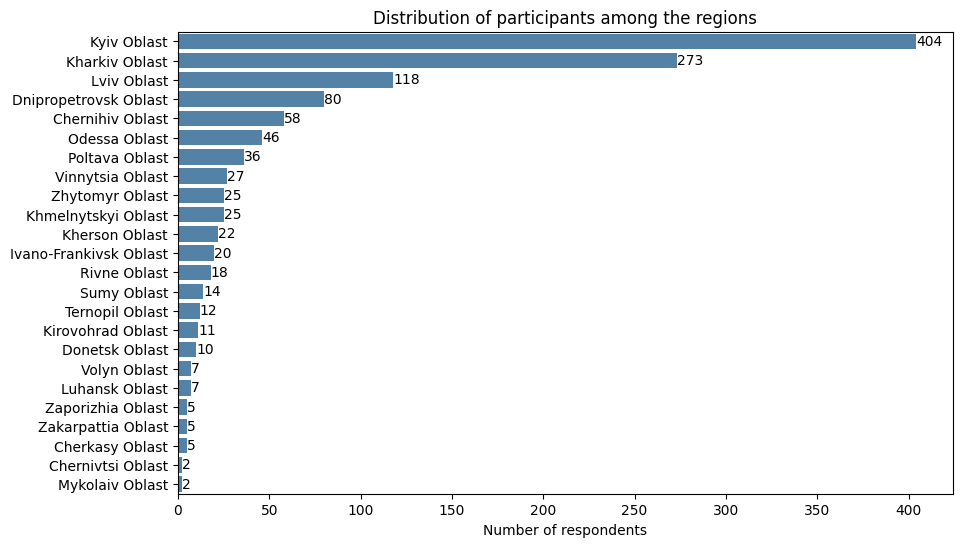

In [673]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(data=df_region,
            y='region_en',
            x='number',
            orient = 'h',
            color='steelblue'
            #stat="percent", 
            #discrete=True
            ).set(title='Distribution of participants among the regions',
            xlabel='Number of respondents',
            ylabel=None
            )
#plt.xticks(rotation=70)
ax.bar_label(ax.containers[0])
plt.show()
fig.savefig('../figs/distribution_regions.jpg')

## Quality of sleep

Plot distribution of quality of sleep before the war

   unique_values    counts
0              4  0.449393
1              5  0.321457
2              3  0.176518
3              2  0.029150
4              0  0.016194
5              1  0.007287


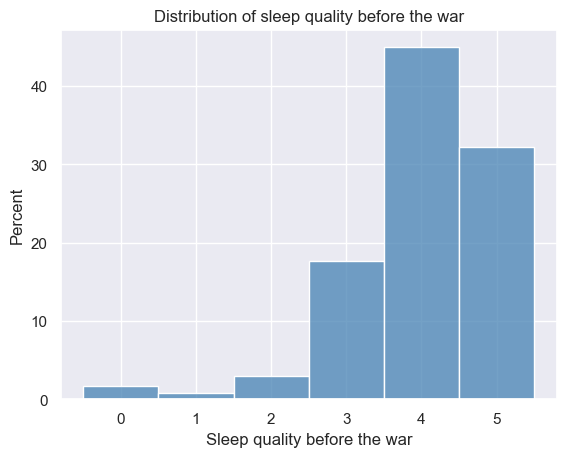

In [781]:
df_qual = df['kidsleep_grade_before'].value_counts(normalize=True).rename_axis('unique_values').reset_index(name='counts')
#print('Distribution of sleep quality before the war in %:\n{}'.format(df["8. –Ø–∫ –≤–∏ –± –æ—Ü—ñ–Ω–∏–ª–∏ —Å–æ–Ω –≤–∞—à–æ—ó –¥–∏—Ç–∏–Ω–∏ –¥–æ 24 –ª—é—Ç–æ–≥–æ? (–≤—ñ–¥ 1 –¥–æ 5, –¥–µ 1 ‚Äì –∂–∞—Ö–ª–∏–≤–∏–π —Å–æ–Ω, 5 ‚Äì —á—É–¥–æ–≤–∏–π —Å–æ–Ω)? "].value_counts(normalize=True)*100))
print(df_qual)
sns.histplot(
        x=df['kidsleep_grade_before'].sort_values(),
        stat="percent",
        color='steelblue',
        discrete=True
        ).set(title='Distribution of sleep quality before the war',
                xlabel='Sleep quality before the war')
plt.show()

## Age of children

### Youngest child

Replace "–î–∏—Ç–∏–Ω–∞ –Ω–∞—Ä–æ–¥–∏–ª–∞—Å—è –ø—ñ—Å–ª—è 24 –ª—é—Ç–æ–≥–æ" with 0 and cast column to int

In [587]:
df['kidsleep_grade_before'] = df['kidsleep_grade_before'].replace('–î–∏—Ç–∏–Ω–∞ –Ω–∞—Ä–æ–¥–∏–ª–∞—Å—è –ø—ñ—Å–ª—è 24 –ª—é—Ç–æ–≥–æ', 0)
df['kidsleep_grade_before'] = df['kidsleep_grade_before'].astype('int')
df['kidsleep_grade_before'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1235 entries, 0 to 1234
Series name: kidsleep_grade_before
Non-Null Count  Dtype
--------------  -----
1235 non-null   int32
dtypes: int32(1)
memory usage: 4.9 KB


In [682]:
sns.set(font_scale=1)

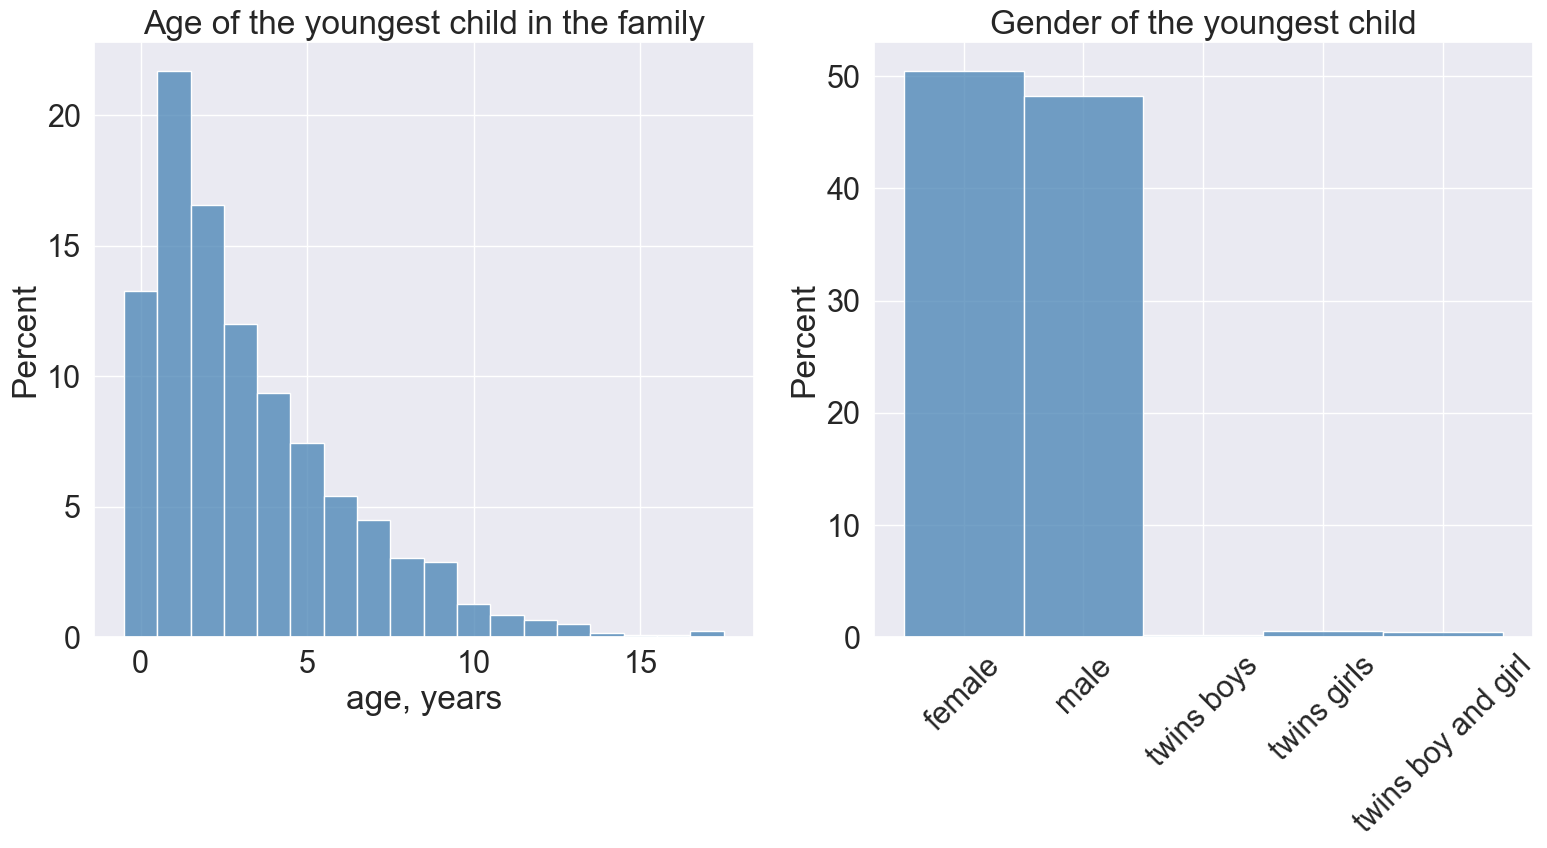

In [678]:
fig, axs = plt.subplots(1, 2, figsize=(16,9), tight_layout=True) #sharey=True to make y axis same
#fig = plt.figure(facecolor=(1, 1, 1))
mask = (df['age_younger']>=0) & (df['age_younger'] <= 18)
#sns.set(font_scale=2)
sns.histplot(ax=axs[0],
                x=df['age_younger'][mask].sort_values(),
                stat="percent",
                color='steelblue',
                discrete=True
                ).set(title='Age of the youngest child in the family',
                        xlabel='age, years')
sns.histplot(ax=axs[1],
        x=df['gender_younger'],
            stat="percent", 
            discrete=True,
            color='steelblue'
            ).set(title='Gender of the youngest child',
            xlabel=None #'gender'
            )
#axs.bar_label(axs.containers[0])
#axs[1].tick_params(rotation=45)
plt.xticks(rotation=45)
fig.savefig('../figs/child_age+gender_2.jpg')
plt.show()

In [48]:
print_all(df.birthday_younger)

0                                           02/08/2016
1                                           07/03/2011
2                                           15/07/2005
3                                           04/11/2016
4                                           23/07/2021
5                                           22/05/2020
6                                           09/03/2021
7                                           02/11/2020
8                                           04/12/2013
9                                           03/06/2021
10                                          20/08/2019
11                                          25/12/2016
12                                          17/10/2017
13                                          29/04/2021
14                                          26/12/2021
15                                          25/09/2020
16                                          11/07/2018
17                                          21/02/2020
18        

In [591]:
# change . and , into "/"

df['birthday_younger'] = df['birthday_younger'].replace(['\.',','],'/', regex=True)

In [592]:
def insert_string_middle(str, word):
    """
    insert the string word in middle of the string, 2 characters before the end
    """
    return str[:-2] + word + str[-2:]

# find rows with a short year (2 digits) and add 20 before the number of the year

df['birthDate_yearShort'] = df['birthday_younger'].apply(lambda x: re.search('\d{1,2}/\d{2}/\d{2}$', x))
df['birthDate_yearShort'] = df['birthDate_yearShort'].apply(lambda x: x.group() if x else x)
#print(df[['birthday_younger','birthDate_yearShort']][df['birthDate_yearShort'].notnull()])

# apply the function for all rows, where the year only has 2 digits

df['birthDate_yearShort'] = df['birthDate_yearShort'][df['birthDate_yearShort'].notnull()].apply(lambda x: insert_string_middle(x, '20'))
#print(df[['birthday_younger','birthDate_yearShort']][df['birthDate_yearShort'].notnull()])
df['birthday_younger'].loc[df['birthDate_yearShort'].notnull()] = df['birthDate_yearShort']


C:\Users\afedorova\AppData\Local\Temp\ipykernel_23444\1139630106.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['birthday_younger'].loc[df['birthDate_yearShort'].notnull()] = df['birthDate_yearShort']


In [593]:
def correct_short_dates_days(column_old, column_new):
    """
    look for dates with one digit day, add a leading zero. 
    only looking for dates with 4 digit year
    fill in the date with leading 0 until it's 10 digits long 
    (should be carried out after all years are 4 digits long)
    """
    df[column_new] = df[column_old].apply(lambda x: re.search('^\d{1,2}/\d{2}/\d{4}', x))
    df[column_new] = df[column_new].apply(lambda x: x.group() if x else x)
    df[column_new] = df[column_new].str.zfill(10)
    return df[column_new]
    #print_all(df[['birthday_younger','birthDate_short']][df.birthDate_short.notnull()])
    #df['birthday_younger'].loc[df.birthDate_short.notnull()] = df['birthDate_short']
    
# look for dates with one digit day, add a leading zero. only looking for dates with 4 digit year

df['birthDate_short'] = df['birthday_younger'].apply(lambda x: re.search('^\d{1,2}/\d{2}/\d{4}', x))
df['birthDate_short'] = df['birthDate_short'].apply(lambda x: x.group() if x else x)

# fill in the date with leading 0 until it's 10 digits long (should be carried out after all years are 4 digits long)

df['birthDate_short'] = df['birthDate_short'].str.zfill(10)
#print_all(df[['birthday_younger','birthDate_short']][df.birthDate_short.notnull()])
df['birthday_younger'].loc[df.birthDate_short.notnull()] = df['birthDate_short']
#print_all(df[['birthday_younger','birthDate_short']][df.birthDate_short.notnull()])

C:\Users\afedorova\AppData\Local\Temp\ipykernel_23444\1317773207.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['birthday_younger'].loc[df.birthDate_short.notnull()] = df['birthDate_short']


In [594]:
def try_parsing_date(text):
    for fmt in ('%Y-%m-%d', '%d.%m.%Y', '%d/%m/%Y'):
        try:
            return datetime.strptime(text, fmt)
        except ValueError:
            pass
    raise ValueError('no valid date format found')

def calculate_age(birthdate, countDate=None):
    """
    returns the float with a full number of years between birthdate and countDate. 
    if countDate is not given, takes todays date
    """
    today = date.today()
    if countDate == None:
        countDate = today
    birthdate = to_datetime(birthdate)
    age = countDate.year - birthdate.year - ((countDate.month, countDate.day) < (birthdate.month, birthdate.day))
    return int(age)

df['birthDate'] = df['birthday_younger'].apply(lambda x: re.search('\d{2}/\d{2}/\d{4}', x))
df['birthDate'] = to_datetime(df['birthDate'].apply(lambda x: x.group() if x else x), format='%d/%m/%Y', dayfirst=True, errors='coerce') #format='%d-%m-%Y',

# calculate age with the function age. Age is calculated on the moment of closing the questionnaire (24.09.2022)
closingDate = datetime(2022, 9, 24)
df['age_younger'] = df['birthDate'][df['birthDate'].notnull()].apply(lambda x: calculate_age(x, closingDate))

In [595]:
# print the results of age calculation

print(f'{df.age_younger.isnull().sum()} birth dates could not be processed:')
print_all( df[['birthday_younger', 'birthDate']][df.age_younger.isnull()])
print(f"{len(df[df['age_younger']<0])} have age under 0:")
print_all(df[['birthday_younger', 'birthDate', 'age_younger']][df['age_younger'] < 0])
print(f"{len(df[df['age_younger'] > 18])} have age over 18:")
print_all(df[['birthday_younger', 'birthDate', 'age_younger']][df['age_younger'] > 18])

38 birth dates could not be processed:
                  birthday_younger birthDate
27                               8       NaT
34                             5/8       NaT
45                           1 —Ä—ñ–∫       NaT
59                         5 —Ä–æ–∫—ñ–≤       NaT
60                    –°–µ—Ä–ø–µ–Ω—å 2017       NaT
78                               6       NaT
139                        2 —Ä–æ–∫–∏        NaT
192                        6 —Ä–æ–∫—ñ–≤       NaT
194                         5—Ä–æ–∫—ñ–≤       NaT
274                    8/5 –º—ñ—Å—è—Ü—ñ–≤       NaT
284                              7       NaT
306                          2/5 —Ä       NaT
309                              9       NaT
354                       6 —Ä–æ–∫—ñ–≤        NaT
405                             10       NaT
411                        6 —Ä–æ–∫—ñ–≤       NaT
427                              5       NaT
483                     02/92/3015       NaT
552                       1/7 —Ä–æ–∫–∏       NaT
553       

Age of the older child

- replace unnecessary punctuation and rows with 0
- replace all '-' (one child) with 0 and all other values with 1 and store in multiple_children column

In [776]:
df.age_older = df['birthday_older'].replace(['\.',','],'/', regex=True)
df.age_older = df.birthday_older.replace(['_', '--','"-"', '^0&'], '-', regex=True)
df.age_older[df.age_older.str.contains('"-"')] = '-'
df.age_older[df.age_older.str.contains('¬´-¬´')] = '-'
df.age_older[df.age_older.str.contains('‚Äú-‚Äú')] = '-'
df.age_older[df.age_older.str.contains('¬´-¬ª')] = '-'
#print_all(df.age_older.value_counts())

df['multiple_children'] = 0
df['multiple_children'][df.age_older == '-'] = 0
df['multiple_children'][df.age_older != '-'] = 1
df['multiple_children'].value_counts()

#df.age_older

C:\Users\afedorova\AppData\Local\Temp\ipykernel_23444\3194926562.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['multiple_children'][df.age_older == '-'] = 0
C:\Users\afedorova\AppData\Local\Temp\ipykernel_23444\3194926562.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['multiple_children'][df.age_older != '-'] = 1


0    804
1    431
Name: multiple_children, dtype: int64

Plot children age distribution based on age_younger column

    unique_values    counts
0             1.0  0.214703
1             2.0  0.163743
2             0.0  0.131161
3             3.0  0.118630
4             4.0  0.092732
5             5.0  0.073517
6             6.0  0.053467
7             7.0  0.044277
8             8.0  0.030075
9             9.0  0.028404
10           10.0  0.012531
11           11.0  0.008354
12           -1.0  0.008354
13           12.0  0.006683
14           13.0  0.005013
15           17.0  0.002506
16           14.0  0.001671
17           15.0  0.000835
18           -8.0  0.000835
19           -5.0  0.000835
20           16.0  0.000835
21           31.0  0.000835


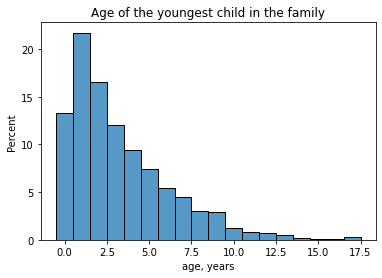

In [597]:
df_age_count = df['age_younger'].value_counts(normalize=True).rename_axis('unique_values').reset_index(name='counts')
#print('Distribution of sleep quality before the war in %:\n{}'.format(df["8. –Ø–∫ –≤–∏ –± –æ—Ü—ñ–Ω–∏–ª–∏ —Å–æ–Ω –≤–∞—à–æ—ó –¥–∏—Ç–∏–Ω–∏ –¥–æ 24 –ª—é—Ç–æ–≥–æ? (–≤—ñ–¥ 1 –¥–æ 5, –¥–µ 1 ‚Äì –∂–∞—Ö–ª–∏–≤–∏–π —Å–æ–Ω, 5 ‚Äì —á—É–¥–æ–≤–∏–π —Å–æ–Ω)? "].value_counts(normalize=True)*100))
print(df_age_count)
img = sns.histplot(
        x=df['age_younger'][(df['age_younger']>=0) & (df['age_younger'] <= 18)].sort_values(),
        stat="percent", 
        discrete=True
        ).set(title='Age of the youngest child in the family',
                xlabel='age, years')
#img.set_xticks(range(18))

plt.show()

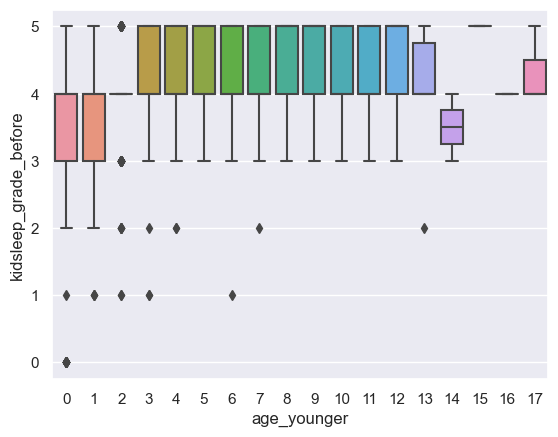

In [705]:
df_age = df[['age_younger', 'kidsleep_grade_before']][df['age_younger']>=0].dropna()
df_age = df_age[df_age['age_younger'] <= 18]
df_age['age_younger'] = df_age['age_younger'].astype('int')

sns.boxplot(data=df_age, x='age_younger', y='kidsleep_grade_before')
plt.show()

In [707]:
df_age = crosstab(index=df_age['age_younger'],
                    columns=df_age['kidsleep_grade_before'],
                    normalize='index')
df_age

kidsleep_grade_before         0         1         2         3         4  \
age_younger                                                               
0                      0.121019  0.006369  0.031847  0.254777  0.356688   
1                      0.000000  0.011673  0.066148  0.291829  0.447471   
2                      0.000000  0.010204  0.025510  0.193878  0.551020   
3                      0.000000  0.014085  0.007042  0.147887  0.514085   
4                      0.000000  0.000000  0.018018  0.063063  0.504505   
5                      0.000000  0.000000  0.000000  0.090909  0.454545   
6                      0.000000  0.015625  0.000000  0.093750  0.453125   
7                      0.000000  0.000000  0.018868  0.056604  0.433962   
8                      0.000000  0.000000  0.000000  0.083333  0.250000   
9                      0.000000  0.000000  0.000000  0.147059  0.294118   
10                     0.000000  0.000000  0.000000  0.066667  0.466667   
11                     0.000000  0.000000  0.000000  0.200000  0.400000   
12                     0.000000  0.000000  0.000000  0.125000  0.250000   
13                     0.000000  0.000000  0.166667  0.000000  0.500000   
14                     0.000000  0.000000  0.000000  0.500000  0.500000   
15                     0.000000  0.000000  0.000000  0.000000  0.000000   
16                     0.000000  0.000000  0.000000  0.000000  1.000000   
17                     0.000000  0.000000  0.000000  0.000000  0.666667   

kidsleep_grade_before         5  
age_younger                      
0                      0.229299  
1                      0.182879  
2                      0.219388  
3                      0.316901  
4                      0.414414  
5                      0.454545  
6                      0.437500  
7                      0.490566  
8                      0.666667  
9                      0.558824  
10                     0.466667  
11                     0.400000  
12                     0.625000  
13                     0.333333  
14                     0.000000  
15                     1.000000  
16                     0.000000  
17                     0.333333

C:\Users\afedorova\AppData\Local\Temp\ipykernel_23444\666378845.py:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('../figs/age_sleepQuality.jpg', tight_layout=True)


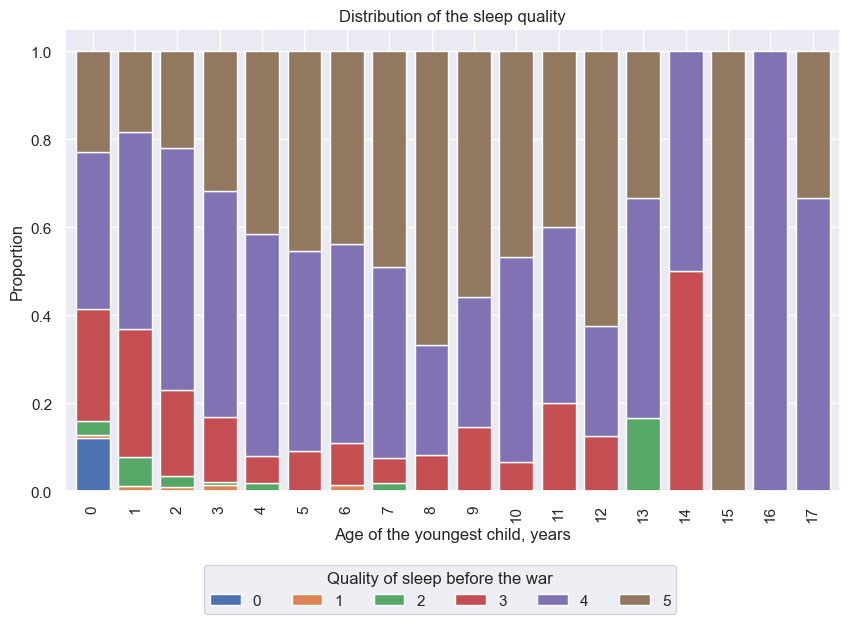

In [758]:
"""
palette = sns.color_palette('YlGnBu')
img = sns.histplot(data=df_age,
                x='age_younger', 
                multiple='fill', 
                hue='kidsleep_grade_before',
                bins=19,
                palette=palette) #.set_xticks(range(18))
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
#img.legend(loc='center left', bbox_to_anchor=(1.25, 0.5))
#plt.legend(loc='upper right')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
"""
df_age.plot(kind='bar',
            stacked=True,
            width=0.8,
            figsize=(10,6))
#box = ax.get_position()

#ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
plt.legend(loc='upper center', 
            ncol=6, 
            bbox_to_anchor=(0.5, 0), 
            bbox_transform=plt.gcf().transFigure,
            title='Quality of sleep before the war')
#plt.tight_layout()
plt.title('Distribution of the sleep quality')
plt.xlabel("Age of the youngest child, years")
plt.ylabel("Proportion")
plt.savefig('../figs/age_sleepQuality.jpg', tight_layout=True)
plt.show()


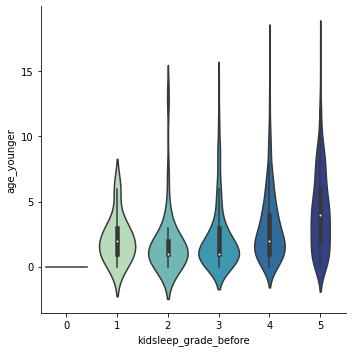

In [94]:
sns.catplot(data=df_age, 
            y='age_younger', 
            x="kidsleep_grade_before", 
            kind='violin'
            )
plt.show()

Subplot with age and gender of the youngest child


In [157]:
fig, axs = plt.subplots(1, 2, figsize=(16,9), tight_layout=True) #sharey=True to make y axis same
#fig = plt.figure(facecolor=(1, 1, 1))
mask = (df['age_younger']>=0) & (df['age_younger'] <= 18)
#sns.set(font_scale=2)
sns.histplot(ax=axs[0],
                x=df['age_younger'][mask].sort_values(),
                stat="percent",
                color='steelblue',
                discrete=True
                ).set(title='Age of the youngest child in the family',
                        xlabel='age, years')
sns.histplot(ax=axs[1],
        x=df['gender_younger'],
            stat="percent", 
            discrete=True,
            color='steelblue'
            ).set(title='Gender of the youngest child',
            xlabel=None #'gender'
            )
#axs.bar_label(axs.containers[0])
#axs[1].tick_params(rotation=45)
plt.xticks(rotation=45)
fig.savefig('../figs/child_age+gender_2.jpg')
plt.show()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1184 entries, 0 to 1234
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age_younger            1184 non-null   float64
 1   kidsleep_grade_before  1184 non-null   int32  
dtypes: float64(1), int32(1)
memory usage: 23.1 KB


## Gender of the youngest child

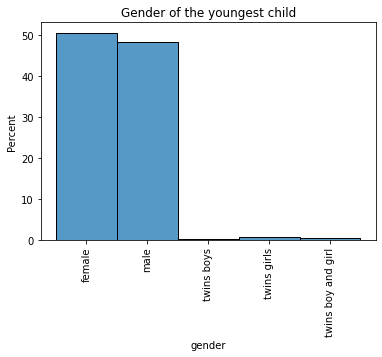

In [598]:
dic_gender = {'–î—ñ–≤—á–∏–Ω–∫–∞': 'female', 
            '–•–ª–æ–ø—á–∏–∫':'male', 
            '–î–≤—ñ–π–Ω—è - –¥–≤–∞ —Ö–ª–æ–ø—á–∏–∫–∏':'twins boys', 
            '–î–≤—ñ–π–Ω—è - –¥–≤—ñ –¥—ñ–≤—á–∏–Ω–∫–∏': 'twins girls', 
            '–î–≤—ñ–π–Ω—è - —Ö–ª–æ–ø—á–∏–∫ —ñ –¥—ñ–≤—á–∏–Ω–∫–∞': 'twins boy and girl', 
            '–û–¥–Ω–∞ –¥–∏—Ç–∏–Ω–∞ ': np.NAN}
df['gender_younger'] = df['gender_younger'].replace(dic_gender).dropna()
sns.histplot(df['gender_younger'],
            stat="percent", 
            discrete=True
            ).set(title='Gender of the youngest child',
            xlabel='gender'
            )
plt.xticks(rotation=90)
plt.show()

## Health issues

Clean the data:
- replace different versions of "no"
- replace answers with 0, when no health issues known and 1, when there were health issues, save to health_short

In [82]:
# TODO: discuss, if ok for the first analysis to have just yes/no
# TODO: if "no + something" - cut the rest after no

#df['health'].value_counts()
df['health'] = df['health'].str.lower()
df.health = df['health'].str.strip()
dic_healthState = {'-':'–Ω—ñ',
                    '"-"':'–Ω—ñ',
                    '–Ω–µ–º–∞—î':'–Ω—ñ',
                    '–Ω–µ –º–∞—î':'–Ω—ñ',
                    '–Ω–µ–º–∞':'–Ω—ñ',
                    '–Ω–µ—Ç':'–Ω—ñ',
                    '–Ω–µ –±—É–ª–æ':'–Ω—ñ',
                    '–Ω—ñ –Ω–µ–º–∞—î':'–Ω—ñ',
                    '–Ω—ñ. –≤—Å–µ –¥–æ–±—Ä–µ':'–Ω—ñ',
                    '–Ω–µ –±—É–ª–æ –æ—Å–æ–±–ª–∏–≤–æ—Å—Ç–µ–π':'–Ω—ñ',
                    'ni':'–Ω—ñ',
                    '–¥–∞': '—Ç–∞–∫'}
df.health = df.health.replace(dic_healthState)

health_dic = {'–Ω—ñ': 0,
                '—Ç–∞–∫': 1}
df['health_short'] = df['health'].replace(health_dic)
df['health_short'].loc[~df['health_short'].isin([0, 1])] = 1
df['health_short'].value_counts()


C:\Users\afedorova\AppData\Local\Temp\ipykernel_23444\3118174790.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['health_short'].loc[~df['health_short'].isin([0, 1])] = 1


0    918
1    317
Name: health_short, dtype: int64

In [538]:
print('–æ—Å–æ–±–ª–∏–≤–æ—Å—Ç—ñ —Å—Ç–∞–Ω—É –∑–¥–æ—Ä–æ–≤‚Äô—è –¥–∏—Ç–∏–Ω–∏ –¥–æ 24 –ª—é—Ç–æ–≥–æ:')
print_all(df.health.value_counts())
#df_health = df.health.value_counts()
#df_health = df_health.reset_index()
#df_health.to_csv('../to_discuss/health_conditions')

–æ—Å–æ–±–ª–∏–≤–æ—Å—Ç—ñ —Å—Ç–∞–Ω—É –∑–¥–æ—Ä–æ–≤‚Äô—è –¥–∏—Ç–∏–Ω–∏ –¥–æ 24 –ª—é—Ç–æ–≥–æ:
–ù—ñ                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

## Left home

In [782]:
print('–ó–∞–ª–∏—à–∞–ª–∏ –º—ñ—Å—Ü–µ –ø—Ä–æ–∂–∏–≤–∞–Ω–Ω—è —Ä–∞–∑–æ–º –∑ –¥—ñ—Ç—å–º–∏\n',
        df['leave_home'].value_counts(normalize=True),
        sep='')

–ó–∞–ª–∏—à–∞–ª–∏ –º—ñ—Å—Ü–µ –ø—Ä–æ–∂–∏–≤–∞–Ω–Ω—è —Ä–∞–∑–æ–º –∑ –¥—ñ—Ç—å–º–∏
–¢–∞–∫    0.820243
–ù—ñ     0.179757
Name: leave_home, dtype: float64


## Changes in sleep behaviour after begin of the war

### Children

In [783]:
print('–ß–∏ –∑–º—ñ–Ω–∏–ª–∞—Å—å –∫—ñ–ª—å–∫—ñ—Å—Ç—å –Ω—ñ—á–Ω–∏—Ö –ø—Ä–æ–±—É–¥–∂–µ–Ω—å –¥–∏—Ç–∏–Ω–∏\n',
    df['night_wakings_after'].value_counts(normalize=True),
    sep='')

–ß–∏ –∑–º—ñ–Ω–∏–ª–∞—Å—å –∫—ñ–ª—å–∫—ñ—Å—Ç—å –Ω—ñ—á–Ω–∏—Ö –ø—Ä–æ–±—É–¥–∂–µ–Ω—å –¥–∏—Ç–∏–Ω–∏
–¢–∞–∫, –¥–µ—â–æ –ø–æ–≥—ñ—Ä—à–∏–ª–∞—Å—è —Å–∏—Ç—É–∞—Ü—ñ—è –≤–Ω–æ—á—ñ        0.573279
–ù—ñ                                          0.302024
–Ø –Ω–µ –∑–≤–µ—Ä—Ç–∞–ª–∞ —É–≤–∞–≥–∏ –Ω–∞ –Ω—ñ—á–Ω—ñ –ø—Ä–æ–±—É–¥–∂–µ–Ω–Ω—è    0.086640
–¢–∞–∫, –¥–µ—â–æ –ø–æ–∫—Ä–∞—â–∏–ª–∞—Å—è —Å–∏—Ç—É–∞—Ü—ñ—è –≤–Ω–æ—á—ñ        0.038057
Name: night_wakings_after, dtype: float64


### Parents

Sleep in February-March

In [466]:
#print_all(df['momsleep_war'].value_counts(normalize=True))
df['momsleep_war_short'] = df['momsleep_war'].str.lower()
df['momsleep_war_short'].loc[df['momsleep_war_short'].str.contains('–Ω–µ —Å–ø–∞–ª–∞', case=False)] = '—Ç–∞–∫'
df['momsleep_war_short'].loc[df['momsleep_war_short'].str.contains('—Ç–∞–∫', case=False)] = '—Ç–∞–∫'
df['momsleep_war_short'].loc[df['momsleep_war_short'].str.contains('–ø–æ–≥–∞–Ω', case=False)] = '—Ç–∞–∫'
df['momsleep_war_short'].loc[df['momsleep_war_short'].str.contains('—Ç—Ä–∏–≤–æ–∂–Ω', case=False)] = '—Ç–∞–∫'
df['momsleep_war_short'] = df['momsleep_war_short'].replace(['–Ω–µ –∑–º—ñ–Ω–∏–≤—Å—è','^-'], '–Ω—ñ', regex=True)
#df['momsleep_war_short'] = df['momsleep_war_short'].replace(['–¢–∞–∫','–±–µ–∑—Å–æ–Ω–Ω—è','—Ç—Ä–∏–≤–æ–∂–Ω–æ', '–ø–æ–≥–∞–Ω–æ'], '—Ç–∞–∫', regex=True)
print_all(df['momsleep_war_short'].value_counts())

—Ç–∞–∫                                                                                                                                                                                                                                                                                                                                                                                                                                                                            568
–Ω—ñ                                                                                                                                                                                                                                                                                                                                                                                                                                                                              15
–±–µ–∑—Å–æ–Ω–Ω—è                                             

In [ ]:
#df['momsleep_war'].loc[df['momsleep_war'] == '-']
print_all(df.loc[df['momsleep_now'].str.contains('—Ç–∞–∫|–ü–æ–∫—Ä–∞—â–∏–≤—Å—è|–∫—Ä–∞—â–µ', case=False), 'momsleep_now'])
df['momsleep_now_short'].loc[df['momsleep_now'].str.contains('—Ç–∞–∫|–ü–æ–∫—Ä–∞—â–∏–≤—Å—è|–∫—Ä–∞—â–µ', case=False), 'momsleep_now'] = '—Ç–∞–∫'

Parents August-September

In [65]:
df['momsleep_now_short'] = df['momsleep_now']
df['momsleep_now_short'] = df['momsleep_now_short'].str.strip().replace('/.', '')
df['momsleep_now_short'] = df['momsleep_now_short'].replace(['–ù—ñ', '–Ω—ñ', '–ú–∞–π–∂–µ –Ω—ñ', '–ù–µ—Ç'], '–Ω—ñ', regex=True)
df['momsleep_now_short'] = df['momsleep_now_short'].replace('–î–∞', '—Ç–∞–∫', regex=True)
df['momsleep_now_short'].loc[df['momsleep_now_short'].str.contains('—Ç–∞–∫|–ü–æ–∫—Ä–∞—â–∏–≤—Å—è|–∫—Ä–∞—â–µ', case=False)] = '—Ç–∞–∫'
print_all(df['momsleep_now_short'].value_counts())

—Ç–∞–∫                                                                                                                                                                                                                                                                                                                                                                                             825
–Ω—ñ                                                                                                                                                                                                                                                                                                                                                                                               73
-                                                                                                                                                                                                                          

C:\Users\afedorova\AppData\Local\Temp\ipykernel_23444\3333467077.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['momsleep_now_short'].loc[df['momsleep_now_short'].str.contains('—Ç–∞–∫|–ü–æ–∫—Ä–∞—â–∏–≤—Å—è|–∫—Ä–∞—â–µ', case=False)] = '—Ç–∞–∫'


## Experience of bomb shelter

In [185]:
print('Experience of going to the bomb shelter or cellar with the child')
df['shelter_experience'].value_counts(normalize=True)

Experience of going to the bomb shelter or cellar with the child


–ù—ñ                    0.349798
–¢–∞–∫, –ø–æ–Ω–∞–¥ 6 —Ä–∞–∑—ñ–≤    0.319028
–¢–∞–∫, 1-2 —Ä–∞–∑–∏         0.204049
–¢–∞–∫, 3-5 —Ä–∞–∑—ñ–≤        0.127126
Name: shelter_experience, dtype: float64

In [186]:
print('Experience of the child sleeping in the bomb shelter or cellar')
df['shelter_kidsleep'].value_counts(normalize=True)

Experience of the child sleeping in the bomb shelter or cellar


–¢–∞–∫                                                  0.415385
–ù—ñ, –º–∏ –Ω–µ –±—É–ª–∏ —ñ —Å—Ö–æ–≤–∏—â—ñ –∑ –¥–∏—Ç–∏–Ω–æ—é                   0.354656
–ù—ñ, –º–∏ –±—É–ª–∏ —Ç–∞–º –∑ –¥–∏—Ç–∏–Ω–æ—é —Ç—ñ–ª—å–∫–∏ –ø—ñ–¥ —á–∞—Å –Ω–µ—Å–ø–∞–Ω–Ω—è    0.229960
Name: shelter_kidsleep, dtype: float64

In [36]:
df.sleep_method_change.value_counts(normalize=True)

–ù—ñ                                                                                                                                                                                                                                                  0.586235
–¢–∞–∫                                                                                                                                                                                                                                                 0.362753
-                                                                                                                                                                                                                                                   0.006478
–ü—ñ—Å–ª—è –ø–æ–≤–µ—Ä–Ω–µ–Ω–Ω—è –¥–æ–¥–æ–º—É - –Ω—ñ. –ó–∞ –∫–æ—Ä–∏–¥–æ—Ä–æ–º - —Ç–∞–∫                                                                                                                                                       

In [74]:
df.loc[(df['shelter_experience'] != '–ù—ñ') & (df['shelter_kidsleep'] == '–ù—ñ, –º–∏ –Ω–µ –±—É–ª–∏ —ñ —Å—Ö–æ–≤–∏—â—ñ –∑ –¥–∏—Ç–∏–Ω–æ—é')]

time                       email location_before  \
129   23.08.2022 22:47:37           oaplume@gmail.com         –î–Ω—ñ–ø—Ä–æ    
186    24.08.2022 6:53:22    lukianovaolena@gmail.com          –•–∞—Ä–∫—ñ–≤   
375   25.08.2022 11:47:45    n.samarets1983@gmail.com        –•–∞—Ä—å–∫–æ–≤    
415   25.08.2022 13:56:17           gory4ka@gmail.com            –ö–∏—ó–≤   
601   26.08.2022 15:01:13     didukolia2111@gmail.com           –õ—å–≤—ñ–≤   
819    31.08.2022 9:20:47      rybalka.2344@gmail.com       –ó–∞–ø–æ—Ä—ñ–∂–∂—è   
867   06.09.2022 14:11:45  anna.gribinukova@gmail.com            –ö–∏—ñ–≤   
1083  07.09.2022 21:39:54       sashazvzvzv@gmail.com          –î–Ω—ñ–ø—Ä–æ   

                  birthday_younger gender_younger age_older gender_older  \
129                     05/02/2021       –î—ñ–≤—á–∏–Ω–∫–∞  6 —Ä–æ–∫—ñ–≤      –î—ñ–≤—á–∏–Ω–∞    
186                     25/05/2020        –•–ª–æ–ø—á–∏–∫         -            -   
375                     17/03/2015       –î—ñ–≤—á–∏–Ω–∫–∞         -            -   
415                     09/02/2017       –î—ñ–≤—á–∏–Ω–∫–∞         -            -   
601                     31/08/2015       –î—ñ–≤—á–∏–Ω–∫–∞         -            -   
819                     01/09/2012       –î—ñ–≤—á–∏–Ω–∫–∞         -            -   
867   2/5 –Ω–∞ –º–æ–º–µ–Ω—Ç 24 –ª—é—Ç–æ–≥–æ 2022        –•–ª–æ–ø—á–∏–∫         -            -   
1083                    02/05/2021       –î—ñ–≤—á–∏–Ω–∫–∞         -            -   

                             feeding       health  kidsleep_grade_before  ...  \
129   –ì—Ä—É–¥–Ω–µ –≤–∏–≥–æ–¥–æ–≤—É–≤–∞–Ω–Ω—è + –ø—Ä–∏–∫–æ—Ä–º            -                      2  ...   
186      –í–∂–µ –ø–µ—Ä–µ–π—à–ª–∏ –Ω–∞ –¥–æ—Ä–æ—Å–ª—É —ó–∂—É           –ù—ñ                      4  ...   
375      –í–∂–µ –ø–µ—Ä–µ–π—à–ª–∏ –Ω–∞ –¥–æ—Ä–æ—Å–ª—É —ó–∂—É       –ù–µ –º–∞—î                      4  ...   
415      –í–∂–µ –ø–µ—Ä–µ–π—à–ª–∏ –Ω–∞ –¥–æ—Ä–æ—Å–ª—É —ó–∂—É           –ù—ñ                      5  ...   
601      –í–∂–µ –ø–µ—Ä–µ–π—à–ª–∏ –Ω–∞ –¥–æ—Ä–æ—Å–ª—É —ó–∂—É           –ù—ñ                      3  ...   
819             –ì—Ä—É–¥–Ω–µ –≤–∏–≥–æ–¥–æ–≤—É–≤–∞–Ω–Ω—è           –ù—ñ                      5  ...   
867      –í–∂–µ –ø–µ—Ä–µ–π—à–ª–∏ –Ω–∞ –¥–æ—Ä–æ—Å–ª—É —ó–∂—É  –ó—É–±–∏ —Ç–∞ –∑—ñ—Ä                      5  ...   
1083     –í–∂–µ –ø–µ—Ä–µ–π—à–ª–∏ –Ω–∞ –¥–æ—Ä–æ—Å–ª—É —ó–∂—É           –ù—ñ                      2  ...   

     informed_consent                                 feedback   city_raw  \
129               –¢–∞–∫  –¢–∞–∫, –≤—ñ–¥–ø–æ–≤—ñ–¥—ñ —ñ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∏ –¥–æ—Å–ª—ñ–¥–∂–µ–Ω–Ω—è     –¥–Ω—ñ–ø—Ä–æ   
186               –¢–∞–∫  –¢–∞–∫, –≤—ñ–¥–ø–æ–≤—ñ–¥—ñ —ñ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∏ –¥–æ—Å–ª—ñ–¥–∂–µ–Ω–Ω—è     —Ö–∞—Ä–∫—ñ–≤   
375               –¢–∞–∫                                       –ù—ñ    —Ö–∞—Ä—å–∫–æ–≤   
415               –¢–∞–∫  –¢–∞–∫, –≤—ñ–¥–ø–æ–≤—ñ–¥—ñ —ñ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∏ –¥–æ—Å–ª—ñ–¥–∂–µ–Ω–Ω—è       –∫–∏—ó–≤   
601               –¢–∞–∫       –¢–∞–∫, —Ç—ñ–ª—å–∫–∏ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∏ –¥–æ—Å–ª—ñ–¥–∂–µ–Ω–Ω—è      –ª—å–≤—ñ–≤   
819               –¢–∞–∫  –¢–∞–∫, –≤—ñ–¥–ø–æ–≤—ñ–¥—ñ —ñ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∏ –¥–æ—Å–ª—ñ–¥–∂–µ–Ω–Ω—è  –∑–∞–ø–æ—Ä—ñ–∂–∂—è   
867               –¢–∞–∫  –¢–∞–∫, –≤—ñ–¥–ø–æ–≤—ñ–¥—ñ —ñ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∏ –¥–æ—Å–ª—ñ–¥–∂–µ–Ω–Ω—è       –∫–∏—ñ–≤   
1083              –¢–∞–∫  –¢–∞–∫, –≤—ñ–¥–ø–æ–≤—ñ–¥—ñ —ñ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∏ –¥–æ—Å–ª—ñ–¥–∂–µ–Ω–Ω—è     –¥–Ω—ñ–ø—Ä–æ   

           city birthDate_yearShort birthDate_short  birthDate age_younger  \
129      –¥–Ω—ñ–ø—Ä–æ                 NaN      05/02/2021 2021-02-05         1.0   
186      —Ö–∞—Ä–∫—ñ–≤                 NaN      25/05/2020 2020-05-25         2.0   
375      —Ö–∞—Ä–∫—ñ–≤                 NaN      17/03/2015 2015-03-17         7.0   
415        –∫–∏—ó–≤                 NaN      09/02/2017 2017-02-09         5.0   
601       –ª—å–≤—ñ–≤                 NaN      31/08/2015 2015-08-31         7.0   
819   –∑–∞–ø–æ—Ä—ñ–∂–∂—è                 NaN      01/09/2012 2012-09-01        10.0   
867        –∫–∏—ó–≤    

## General information about parents

### Age

In [509]:
df.age = df.age.astype('int')
#df.age.value_counts()
#sns.displot(df.age)

['04.04.1990', '01.12.1992', '22.08.1997', '26.02.1978', '01.01.1985', '16.07.1995'] 2022-09-24 00:00:00


c:\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


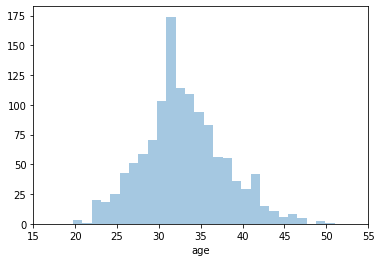

In [513]:
# age distribution
df.age = df.age.replace(' —Ä–æ–∫–∏', '', regex = True)
df.age.loc[df.age == '26 —Ä–æ–∫—ñ–≤, (14.08.1996) '] = 26
df.age = df.age.replace('–ù–µ–¥–∞–≤–Ω–æ —Å—Ç—É–∫–Ω–æ–ª–æ 38', '38')

# replace values for rows with dates of birth using user function calculate_age
age_to_calculate = ['04.04.1990',
                    '01.12.1992',
                    '22.08.1997',
                    '26.02.1978',
                    '01.01.1985',
                    '16.07.1995']
#print(age_to_calculate, closingDate)
age_calculated = {}
for a in age_to_calculate:
    age_calculated[a] = calculate_age(to_datetime(a, format='%d.%m.%Y'), closingDate)

df.age = df.age.replace(age_calculated)
df.age.value_counts()

i = df[df.age == '–°–ø–æ–∫—ñ—é'].index
df = df.drop(i)

sns.distplot(df.age, kde=False)
plt.xlim(15, 55)
plt.show()


### Education

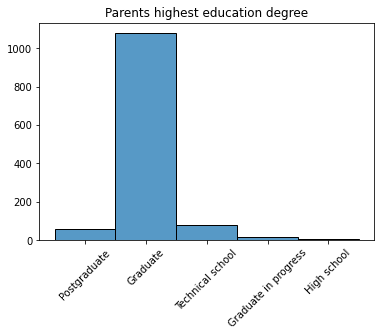

In [521]:
edu = {'–®–∫—ñ–ª—å–Ω–∞':'High school',
    '–°–µ—Ä–µ–¥–Ω—è —Å–ø–µ—Ü—ñ–∞–ª—å–Ω–∞': 'Technical school',
    '–í–∏—â–∞ (–≤ –ø—Ä–æ—Ü–µ—Å—ñ –Ω–∞–≤—á–∞–Ω–Ω—è)':'Graduate in progress',
    '–í–∏—â–∞ (–±–∞–ª–∞–ª–∞–≤—Ä, –º–∞–≥—ñ—Å—Ç—Ä)': 'Graduate',
    '–ù–∞—É–∫–æ–≤–∏–π —Å—Ç—É–ø—ñ–Ω—å (–∫–∞–Ω–¥–∏–¥–∞—Ç, –¥–æ–∫—Ç–æ—Ä –Ω–∞—É–∫)':'Postgraduate'
    }

df.education_en = df.education.replace(edu)
df.education_en.value_counts()
sns.histplot(df.education_en,
            discrete=True
            ).set(title='Parents highest education degree',
            xlabel=None,
            ylabel=None
            )
plt.xticks(rotation=45)
plt.show()

In [542]:
df_relationship = read_csv('../data/relationship_outliers.csv')
dic_relationship = df_relationship.dropna().set_index('index')['change'].to_dict()
dic_relationship

{'–í—Å–µ —Å–∫–ª–∞–¥–Ω–æ': '–ù–µ–≤–∏–∑–Ω–∞—á–µ–Ω–∏–π',
 '–£ —Ä–æ–∑–ª—É—Ü—ñ —É–∂–µ –ø—ñ–≤—Ä–æ–∫—É': '–£ —à–ª—é–±—ñ',
 '–ó–∞–º—ñ–∂–Ω—è, –∞–ª–µ –∑–∞—Ä–∞–∑ –∂–∏–≤—É –∑ –¥–∏—Ç–∏–Ω–æ—é –≤ –º–æ—ó—Ö –±–∞—Ç—å–∫—ñ–≤, —á–æ–ª–æ–≤—ñ–∫ –ø–æ–≤–µ—Ä–Ω—É–≤—Å—è –≤ –Ü—Ä–ø—ñ–Ω—å. –ü—Ä–∏—ñ–∑–∂–∞—î –¥–æ –Ω–∞—Å –Ω–∞ 2 –¥–Ω—ñ –≤ –º—ñ—Å—è—Ü—å ': '–£ —à–ª—é–±—ñ',
 '–ß–æ–ª–æ–≤—ñ–∫ –Ω–∞—Å –ø–æ–∫–∏–Ω—É–≤, –∞–ª–µ –ø—ñ–¥—Ç—Ä–∏–º—É—î–º–æ –ø–æ–≤–∞–∂–Ω—ñ —Å—Ç–æ—Å—É–Ω–∫–∏, –∑ –¥–∏—Ç–∏–Ω–æ—é –Ω–µ –±–∞—á–∏–≤—Å—è —ñ –æ—Å–æ–±–ª–∏–≤–æ –Ω–µ —Å–ø—ñ—à–∏—Ç—å, –¥—ñ–∑–Ω–∞—î—Ç—å—Å—è —è–∫ —Å–ø—Ä–∞–≤–∏, –∞–ª–µ –ø–æ –≤—ñ–¥–µ –∞–±–æ —Ç–µ–ª–µ—Ñ–æ–Ω—É —Å–ø—ñ–ª–∫—É–≤–∞–≤—Å—è 5 —Ä–∞–∑—ñ–≤ –∑–∞ –ø—ñ–≤—Ä–æ–∫—É': '–ù–µ–≤–∏–∑–Ω–∞—á–µ–Ω–∏–π',
 '–ü—Ä–æ–∂–∏–≤–∞—é –∑ –±–∞—Ç—å–∫–∞–º–∏ —Ç–∞ –¥–∏—Ç–∏–Ω–æ—é –∑–∞ –∫–æ—Ä–¥–æ–Ω–æ–º': '–£ —à–ª—é–±—ñ',
 '–ß–µ–∫–∞—é –Ω–∞ —á–æ–ª–æ–≤—ñ–∫–∞, –Ω–∞–º–∞–≥–∞—î–º–æ—Å—è –∑—É—Å—Ç—Ä—ñ—Ç–∏—Å—è': '–£ —à–ª—é–±—ñ',
 '–ø—ñ—Å–ª—è –æ–∫—É–ø–∞—Ü—ñ—ó –ø—Ä–∏–π–Ω—è–ª–∏ —Ä—ñ—à–µ–Ω–Ω—è –æ–¥—Ä—É–∂–∏—Ç–∏—Å—å, 20.08 –æ–¥—Ä—É–∂–∏–ª–∏—Å—è

In [788]:
df.relationship_short = df.relationship

df.relationship_short.loc[df.relationship.str.contains('–£ —à–ª—é–±—ñ', case=False)] = '–£ —à–ª—é–±—ñ'
df.relationship_short.loc[df.relationship.str.contains('–≤–¥–æ–≤–∞', case=False)] = '–í–¥–æ–≤–∞'
df.relationship_short.loc[df.relationship.str.contains('—Ä–æ–∑–ª—É—á–µ–Ω', case=False)] = '–†–æ–∑–ª—É—á–µ–Ω—ñ'
df.relationship_short.loc[df.relationship.str.contains('–ó–∞–º—É–∂–µ–º', case=False)] = '–£ —à–ª—é–±—ñ'
df.relationship_short = df.relationship_short.replace(dic_relationship)


C:\Users\afedorova\AppData\Local\Temp\ipykernel_23444\901662329.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.relationship_short = df.relationship
C:\Users\afedorova\AppData\Local\Temp\ipykernel_23444\901662329.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.relationship_short.loc[df.relationship.str.contains('–£ —à–ª—é–±—ñ', case=False)] = '–£ —à–ª—é–±—ñ'
C:\Users\afedorova\AppData\Local\Temp\ipykernel_23444\901662329.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.relationship_

In [792]:
df.relationship_short.loc[df.relationship_short == ''] = '–ù–µ–≤–∏–∑–Ω–∞—á–µ–Ω–∏–π'
#df_relationship = df_regions.set_index('village')['region'].to_dict()
df.relationship_short.value_counts()

–£ —à–ª—é–±—ñ                        1120
–ü—Ä–æ–∂–∏–≤–∞—é —Å–∞–º (-–∞) –∑ –¥–∏—Ç–∏–Ω–æ—é      42
–£ —Å—Ç–æ—Å—É–Ω–∫–∞—Ö –∑ –ø–∞—Ä—Ç–Ω–µ—Ä–æ–º          34
–†–æ–∑–ª—É—á–µ–Ω—ñ                        28
–ù–µ–≤–∏–∑–Ω–∞—á–µ–Ω–∏–π                      7
–í–¥–æ–≤–∞                             4
Name: relationship, dtype: int64

In [537]:
df_relationship = df.relationship_short.value_counts()
df_relationship = df_relationship.reset_index()